<h1>Projet Scoring<H1>

#**Modules et packages utilisées**

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score,recall_score, confusion_matrix, make_scorer
from sklearn import tree
from tqdm import tqdm
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler,NearMiss


# **Analyse exploratoire des données**

In [6]:
df = pd.read_csv('hmeq.csv') #chargement du jeu de données

In [7]:
#distinction des variables numériques
numerical_columns = df[['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']]

In [8]:
numerical_columns.describe()

LOAN        MORTDUE          VALUE          YOJ        DEROG  \
count   5960.000000    5442.000000    5848.000000  5445.000000  5252.000000   
mean   18607.969799   73760.817200  101776.048741     8.922268     0.254570   
std    11207.480417   44457.609458   57385.775334     7.573982     0.846047   
min     1100.000000    2063.000000    8000.000000     0.000000     0.000000   
25%    11100.000000   46276.000000   66075.500000     3.000000     0.000000   
50%    16300.000000   65019.000000   89235.500000     7.000000     0.000000   
75%    23300.000000   91488.000000  119824.250000    13.000000     0.000000   
max    89900.000000  399550.000000  855909.000000    41.000000    10.000000   

            DELINQ        CLAGE         NINQ         CLNO      DEBTINC  
count  5380.000000  5652.000000  5450.000000  5738.000000  4693.000000  
mean      0.449442   179.766275     1.186055    21.296096    33.779915  
std       1.127266    85.810092     1.728675    10.138933     8.601746  
min       0.000000     0.000000     0.000000     0.000000     0.524499  
25%       0.000000   115.116702     0.000000    15.000000    29.140031  
50%       0.000000   173.466667     1.000000    20.000000    34.818262  
75%       0.000000   231.562278     2.000000    26.000000    39.003141  
max      15.000000  1168.233561    17.000000    71.000000   203.312149

## Taille du dataset

In [9]:
df.shape

(5960, 13)

In [10]:
df.head()

BAD  LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0    1  1100  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   
1    1  1300  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0   
2    1  1500  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0   
3    1  1500      NaN       NaN      NaN     NaN   NaN    NaN     NaN   
4    0  1700  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   

        CLAGE  NINQ  CLNO  DEBTINC  
0   94.366667   1.0   9.0      NaN  
1  121.833333   0.0  14.0      NaN  
2  149.466667   1.0  10.0      NaN  
3         NaN   NaN   NaN      NaN  
4   93.333333   0.0  14.0      NaN

## Apercu géneral

In [11]:
df.dtypes #types des données

BAD          int64
LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

Les variables explicatives se distinguent comme suit:

*   Variables catégorielles : Job et Reason
*   Variables quantitatifs: Loan, Mortdue, Value, Yoj, Derog, Delinq, Clage, Ninq, Clno et Debtinq

La variable cible BAD est une variable binaire


In [12]:

df['LOAN']=df["LOAN"].astype("float")
df["REASON"]=df["REASON"].astype("category")
df["JOB"]=df["JOB"].astype("category")

### Pourcentage des valeurs manquantes

In [13]:
((df.isna().sum()/df.shape[0]).sort_values(ascending=True))*100

BAD         0.000000
LOAN        0.000000
VALUE       1.879195
CLNO        3.724832
REASON      4.228188
JOB         4.681208
CLAGE       5.167785
NINQ        8.557047
YOJ         8.640940
MORTDUE     8.691275
DELINQ      9.731544
DEROG      11.879195
DEBTINC    21.258389
dtype: float64

### La variable cible

In [14]:
df["BAD"].value_counts(normalize=True)

0    0.800503
1    0.199497
Name: BAD, dtype: float64

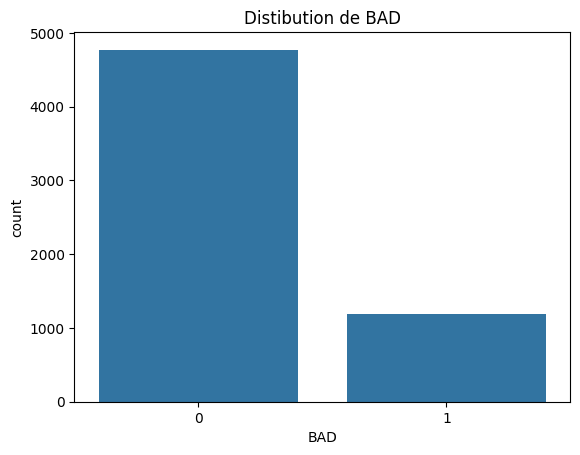

In [15]:
#la distribution de la variable cible
sns.countplot(x='BAD', data=df)
plt.xlabel('BAD')
plt.ylabel('count')
plt.title('Distibution de BAD')
plt.show()

On remarque un déséquilibre au niveau de la variable réponse. 80% des observations sont à 0 tandis que seulement 20% sont à 1.

### Les variables catégorielles

In [16]:
df["JOB"].unique()

['Other', NaN, 'Office', 'Sales', 'Mgr', 'ProfExe', 'Self']
Categories (6, object): ['Mgr', 'Office', 'Other', 'ProfExe', 'Sales', 'Self']

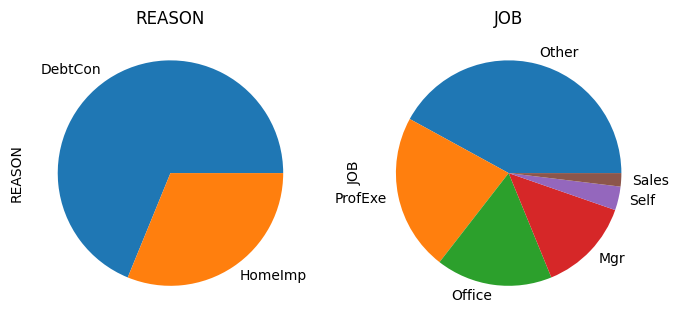

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
cat_vars = [col for col in df.select_dtypes('category')]
for ax, var in zip(axs.flatten(), cat_vars):
    df[var].value_counts().plot.pie(ax=ax)
    ax.set(title=var)
plt.show()

In [18]:
df["REASON"].unique()

['HomeImp', NaN, 'DebtCon']
Categories (2, object): ['DebtCon', 'HomeImp']

In [19]:
df["JOB"].value_counts(normalize=True)

Other      0.420349
ProfExe    0.224608
Office     0.166872
Mgr        0.135011
Self       0.033973
Sales      0.019187
Name: JOB, dtype: float64

"Other" représente 42.03% de tous les emplois répertoriés dans le jeu de données.
22.45 sont des personnels exécutifs (directeurs , managers...), 16.68% ont des emplois de bureau ou administratifs, 13.5% occupent des postes de gestion, 3.39% sont des indépendants(entrepreneurs ...) et 1.92 % travaillent dans le commercial.

In [20]:
df['REASON'].value_counts(normalize=True)

DebtCon    0.688157
HomeImp    0.311843
Name: REASON, dtype: float64

31% des personnes ont obtenu un pret pour réaliser des améliorations ou rénovations de leur habitat tandis que 68% l'ont obtenu pour réaliser une consolidation de dettes.

## Relation BAD / Variables catégorielles

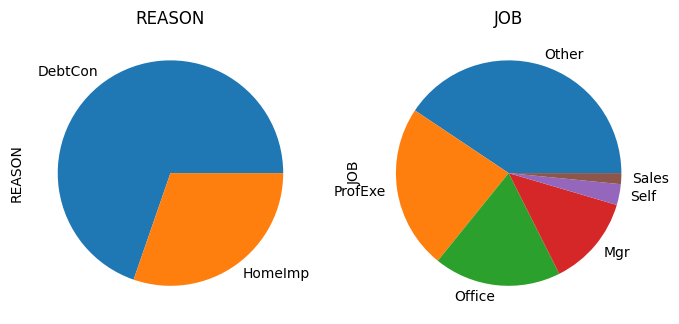

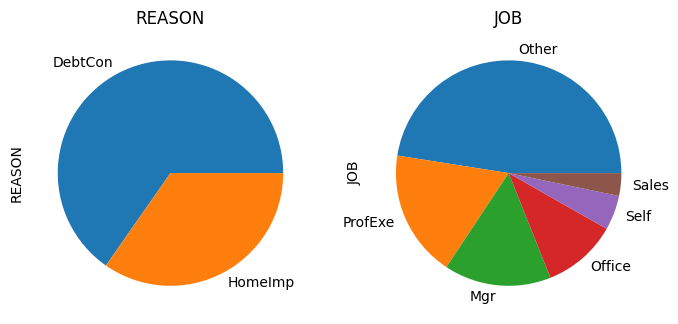

In [21]:
df_bad_0 = df[df['BAD'] == 0]
df_bad_1 = df[df['BAD'] == 1]
for data in [df_bad_0,df_bad_1]:
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
  cat_vars = [col for col in data.select_dtypes('category')]
  for ax, var in zip(axs.flatten(), cat_vars):
      data[var].value_counts().plot.pie(ax=ax)
      ax.set(title=var)
  plt.show()

In [22]:
pd.crosstab(df['BAD'],df['JOB'], normalize='columns') * 100

JOB        Mgr     Office     Other   ProfExe      Sales       Self
BAD                                                                
0    76.662321  86.814346  76.80067  83.38558  65.137615  69.948187
1    23.337679  13.185654  23.19933  16.61442  34.862385  30.051813

On remarque que les personnes qui travaillent dans lés métiers des personnels exécutifs, administration, gestion et other ont le taux le plus élevé de rembourssement de dettes et qui est supérieur à 75% et un pourcentage de tomber en défaut inférieur à  24%
Les entrepreneurs et les métiers de commerce sont plus susceptibles de tomber en défaut par rapport aux autres métiers, avec un pourcentage supérieur à 30 %

In [23]:
pd.crosstab(df['BAD'],df['REASON'],normalize='columns') * 100

REASON    DebtCon    HomeImp
BAD                         
0       81.033605  77.752809
1       18.966395  22.247191

81% qui prennent un crédit pour consolidation de dettes ne tombent pas en défaut et 76% des gens qui prennet un crédit pour la rénovation ne tombent pas aussi en défaut. Les deux sont des taux élvés et rassurant mais ceci est du au fait qu on a peu de valeurs = 1 pour la variable BAD dans notre dataset

## Relation BAD /  variables quantitatifs

In [24]:
df_numerical=df[["LOAN", "MORTDUE", "VALUE", "YOJ", "DEROG", "DELINQ", "CLAGE", "NINQ", "CLNO" ,"DEBTINC","BAD"]]

###Distribution des variables selon BAD

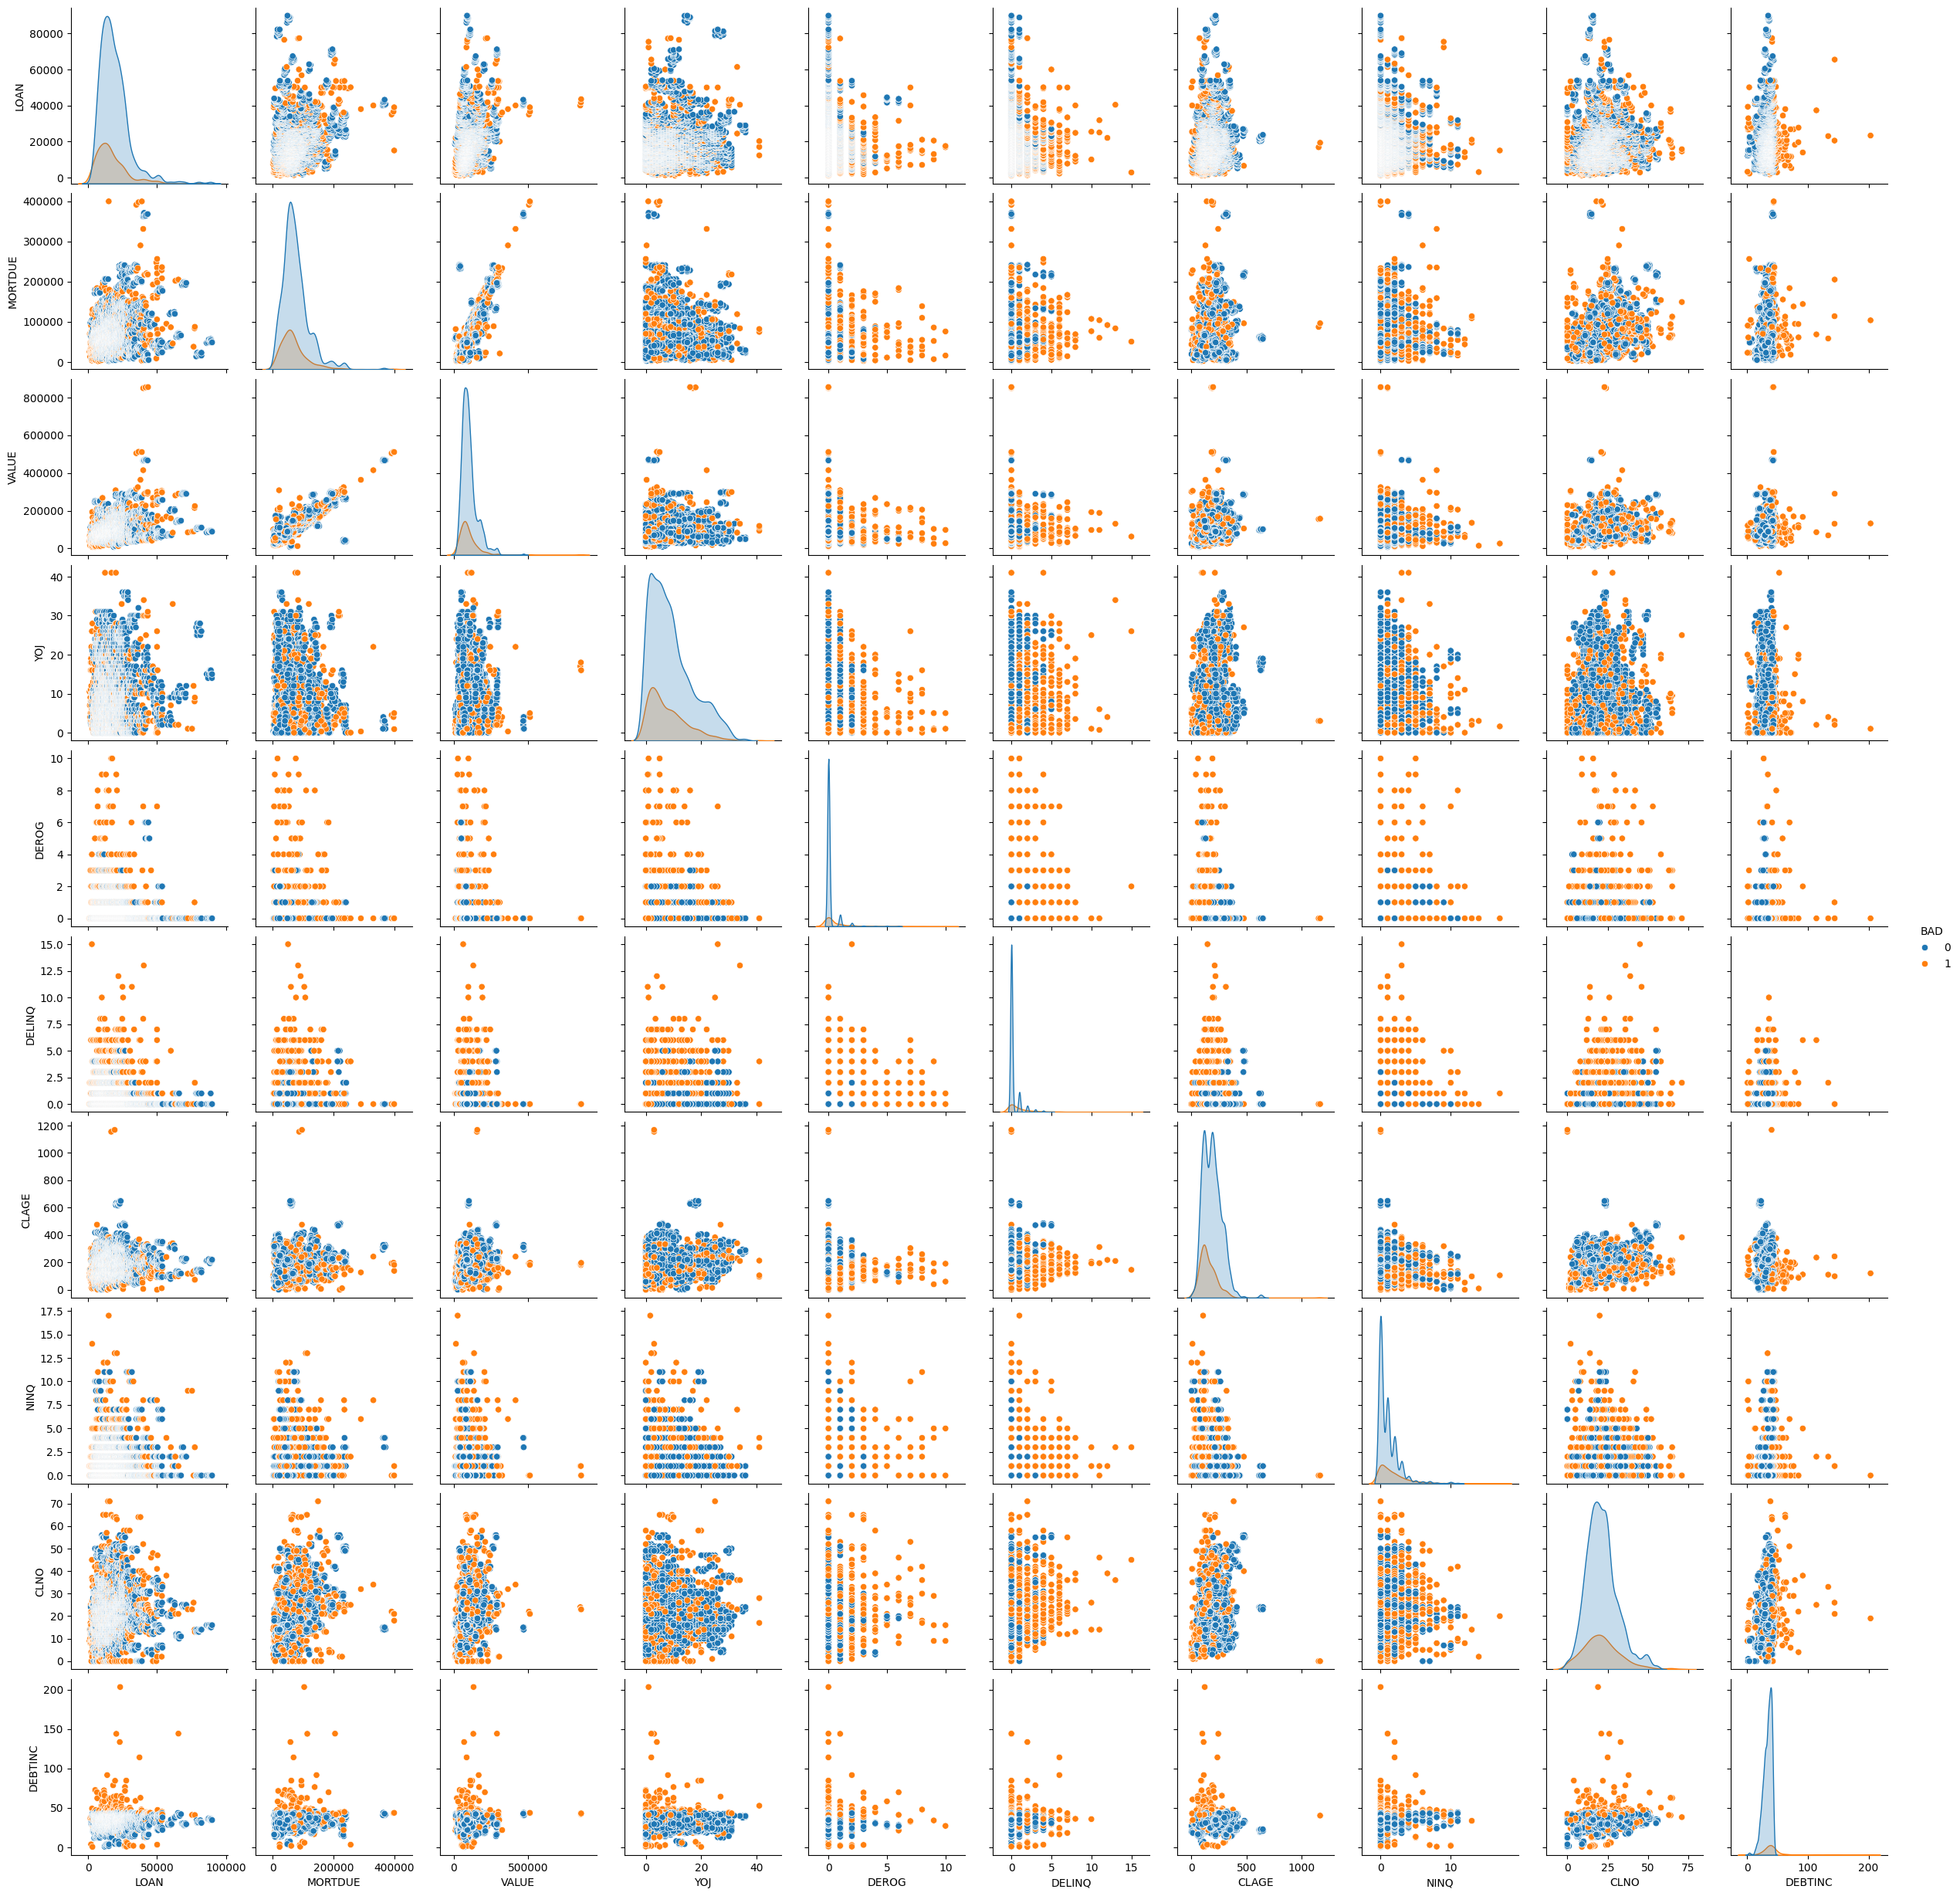

In [25]:
sns.pairplot(df_numerical, hue='BAD')

On remarque une relation linéraire entre mortdue et value

### Analyse de corrélation

<Axes: >

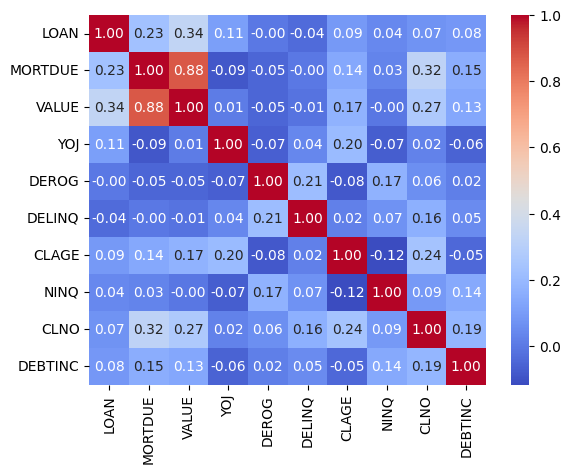

In [26]:
df_numerical_variables = df_numerical.drop(columns = 'BAD')
sns.heatmap(df_numerical_variables.corr(), annot=True, cmap='coolwarm', fmt=".2f")

Comme on  a remarqué avant, les deux variables mortdue et value sont les seuls
qui sont significativement corrélés avec un taux de corrélation égal à 0.88%

### Durée dans le Job YOJ / BAD

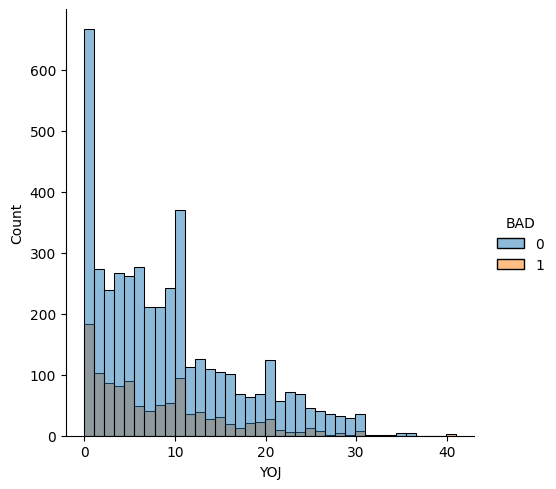

In [27]:
sns.displot(df, x= 'YOJ', hue='BAD')

On ne remarque pas d'infos util qui pourra nous aider à supposer que  si cette personne a travaillé moins de x ans , elle est susceptible de tomber en defaut

In [28]:
print(df[df['YOJ'] <= 10].shape[0]/df.shape[0])
df_bad = df[df['BAD']== 1]
print(df_bad[df['YOJ'] <=10].shape[0]/df.shape[0])

0.6145973154362416
0.1332214765100671


<ipython-input-28-2cc39421f49f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_bad[df['YOJ'] <=10].shape[0]/df.shape[0])


61% de la population ont passé entre 0 et 10 ans dans leur job mais que 13% d'eux sont en défaut ... (J'ai fait cette étude pour voir si les personnes qui viennet de commencer à travailler sont les plus à trouver des difficultés pour rembourser leurs dettes)

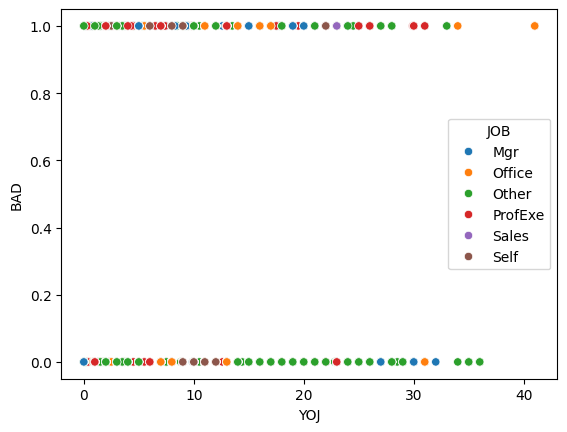

In [29]:
sns.scatterplot(x='YOJ', y='BAD', data=df, hue='JOB')
plt.show()

On ne peut pas distinguer des tranches pour les années passés dans une catégorie soci-professionnelle pour dire si cette personne a plus ou moins de chance de tomber en défaut. Mais pour other , entre 13 et 22 ils ne sont majoritairement pas en défaut.

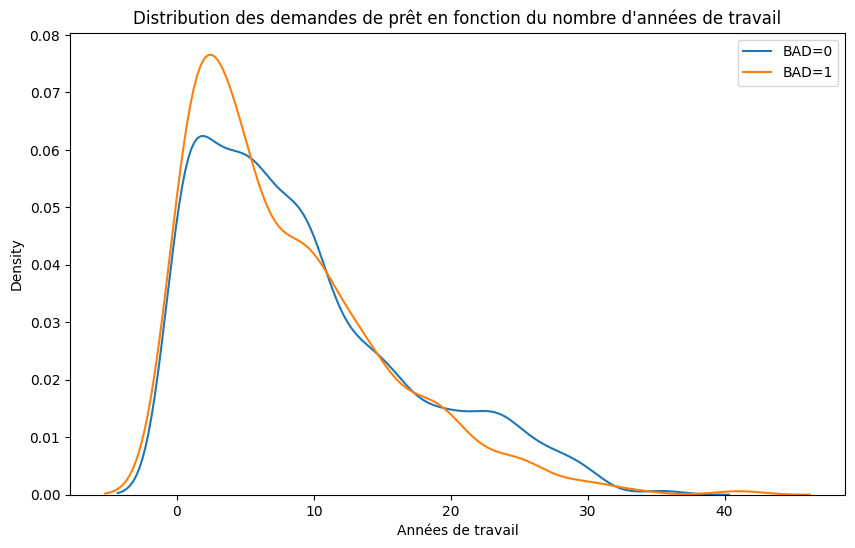

In [30]:
df_bad_0 = df[df['BAD'] == 0]
df_bad_1 = df[df['BAD'] == 1]

plt.figure(figsize=(10, 6))
sns.kdeplot(df_bad_0['YOJ'], label='BAD=0')
sns.kdeplot(df_bad_1['YOJ'], label='BAD=1')
plt.title('Distribution des demandes de prêt en fonction du nombre d\'années de travail')
plt.xlabel('Années de travail')
plt.ylabel('Density')
plt.legend()
plt.show()

In [31]:
df.head()

BAD    LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0    1  1100.0  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   
1    1  1300.0  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0   
2    1  1500.0  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0   
3    1  1500.0      NaN       NaN      NaN     NaN   NaN    NaN     NaN   
4    0  1700.0  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   

        CLAGE  NINQ  CLNO  DEBTINC  
0   94.366667   1.0   9.0      NaN  
1  121.833333   0.0  14.0      NaN  
2  149.466667   1.0  10.0      NaN  
3         NaN   NaN   NaN      NaN  
4   93.333333   0.0  14.0      NaN

### Nombre de rapports majeurs défavorables DEROG / BAD

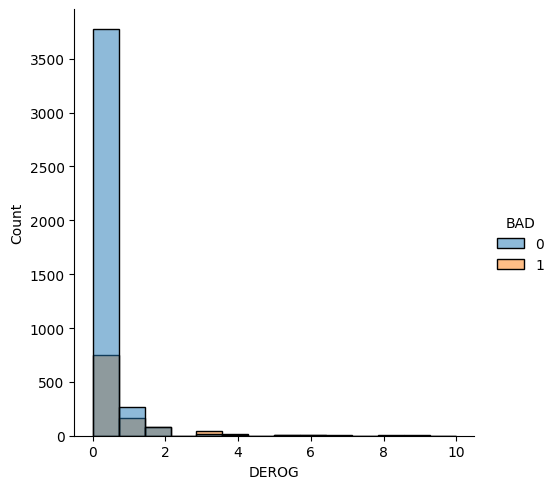

In [32]:
sns.displot(df, x='DEROG', hue = 'BAD')

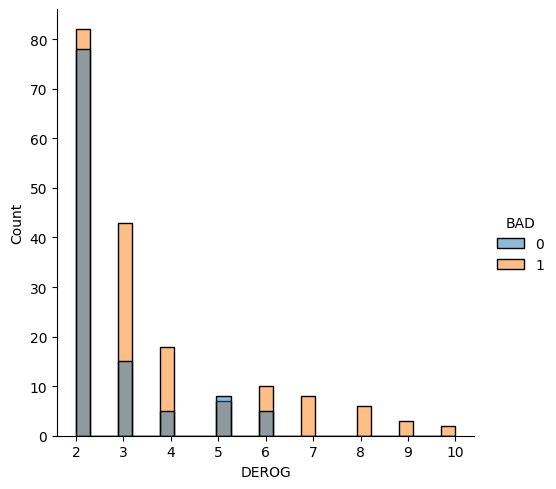

In [33]:
b = df[df['DEROG'] > 1]
sns.displot(b, x='DEROG', hue = 'BAD')

In [34]:
df

BAD     LOAN  MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
0       1   1100.0  25860.0   39025.0  HomeImp   Other  10.5    0.0     0.0   
1       1   1300.0  70053.0   68400.0  HomeImp   Other   7.0    0.0     2.0   
2       1   1500.0  13500.0   16700.0  HomeImp   Other   4.0    0.0     0.0   
3       1   1500.0      NaN       NaN      NaN     NaN   NaN    NaN     NaN   
4       0   1700.0  97800.0  112000.0  HomeImp  Office   3.0    0.0     0.0   
...   ...      ...      ...       ...      ...     ...   ...    ...     ...   
5955    0  88900.0  57264.0   90185.0  DebtCon   Other  16.0    0.0     0.0   
5956    0  89000.0  54576.0   92937.0  DebtCon   Other  16.0    0.0     0.0   
5957    0  89200.0  54045.0   92924.0  DebtCon   Other  15.0    0.0     0.0   
5958    0  89800.0  50370.0   91861.0  DebtCon   Other  14.0    0.0     0.0   
5959    0  89900.0  48811.0   88934.0  DebtCon   Other  15.0    0.0     0.0   

           CLAGE  NINQ  CLNO    DEBTINC  
0      94.366667   1.0   9.0        NaN  
1     121.833333   0.0  14.0        NaN  
2     149.466667   1.0  10.0        NaN  
3            NaN   NaN   NaN        NaN  
4      93.333333   0.0  14.0        NaN  
...          ...   ...   ...        ...  
5955  221.808718   0.0  16.0  36.112347  
5956  208.692070   0.0  15.0  35.859971  
5957  212.279697   0.0  15.0  35.556590  
5958  213.892709   0.0  16.0  34.340882  
5959  219.601002   0.0  16.0  34.571519  

[5960 rows x 13 columns]

In [35]:
import pandas as pd
values_for_bad_1 = df[df['BAD'] == 1]['DEROG'].unique()
values_for_bad_0 = df[df['BAD'] == 0]['DEROG'].unique()
values_only_with_bad_1 = [value for value in values_for_bad_1 if value not in values_for_bad_0]
print("Valeurs de DEROG pour lesquelles BAD est égal à 1:", values_for_bad_1)
print("Valeurs de DEROG pour lesquelles BAD est égal à 0:", values_for_bad_0)
print("Valeurs de DEROG pour lesquelles BAD est uniquement égal à 1:", values_only_with_bad_1)

Valeurs de DEROG pour lesquelles BAD est égal à 1: [ 0. nan  3.  2.  1.  4.  5.  6.  7.  8.  9. 10.]
Valeurs de DEROG pour lesquelles BAD est égal à 0: [ 0. nan  2.  1.  4.  3.  6.  5.]
Valeurs de DEROG pour lesquelles BAD est uniquement égal à 1: [nan, 7.0, 8.0, 9.0, 10.0]


On peut supposer que  si la personne a strictement plus que 6 rapports majeurs défavorables elle est en défaut

### Nombre de paiements en retard DELINQ / BAD

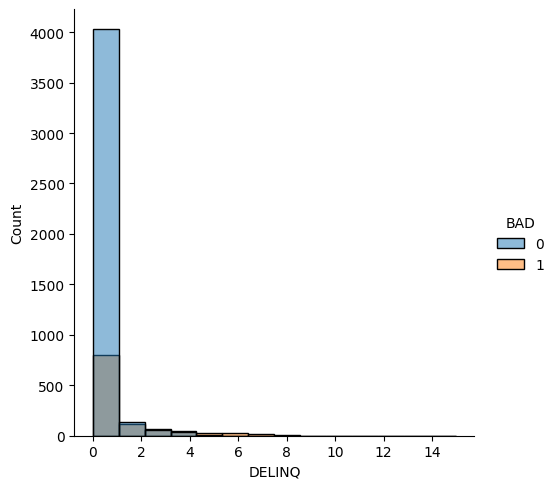

In [36]:
sns.displot(df, x= 'DELINQ', hue = 'BAD')

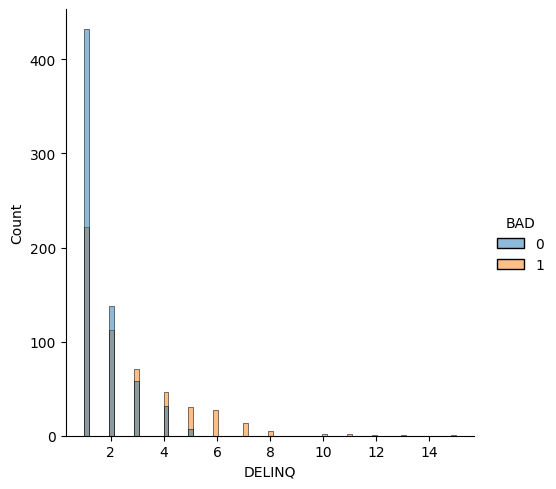

In [37]:
b = df[df['DELINQ'] > 0.5]
sns.displot(b, x='DELINQ', hue = 'BAD')

Si le nombre de paiements en retard est sup a 5, la personne est suceptible de tomber en défaut

In [38]:
import pandas as pd
values_for_bad_1 = df[df['BAD'] == 1]['DELINQ'].unique()
values_for_bad_0 = df[df['BAD'] == 0]['DELINQ'].unique()
values_only_with_bad_1 = [value for value in values_for_bad_1 if value not in values_for_bad_0]
print("Valeurs de DELINQ pour lesquelles BAD est égal à 1:", values_for_bad_1)
print("Valeurs de DELINQ pour lesquelles BAD est égal à 0:", values_for_bad_0)
print("Valeurs de DELINQ pour lesquelles BAD est uniquement égal à 1:", values_only_with_bad_1)

Valeurs de DELINQ pour lesquelles BAD est égal à 1: [ 0.  2. nan  1.  6. 15.  4.  3.  5.  7.  8. 10. 12. 11. 13.]
Valeurs de DELINQ pour lesquelles BAD est égal à 0: [ 0.  2. nan  1.  4.  3.  5.]
Valeurs de DELINQ pour lesquelles BAD est uniquement égal à 1: [nan, 6.0, 15.0, 7.0, 8.0, 10.0, 12.0, 11.0, 13.0]


On peut supposer que  si la personne a strictement plus que 6 paiements en retard elle est en défaut.

### Nombre de lignes de crédit CLNO / BAD

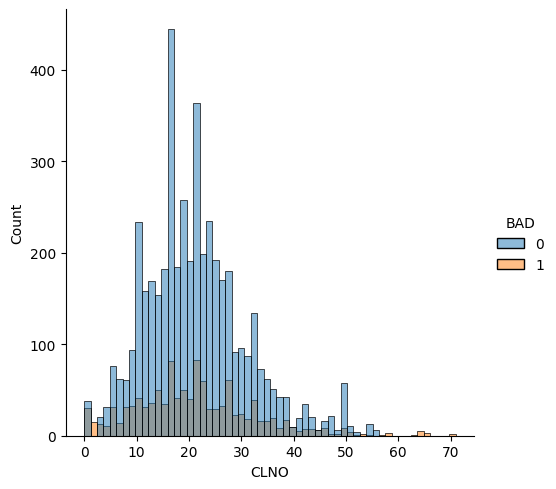

In [39]:
sns.displot(df, x= 'CLNO', hue = 'BAD')

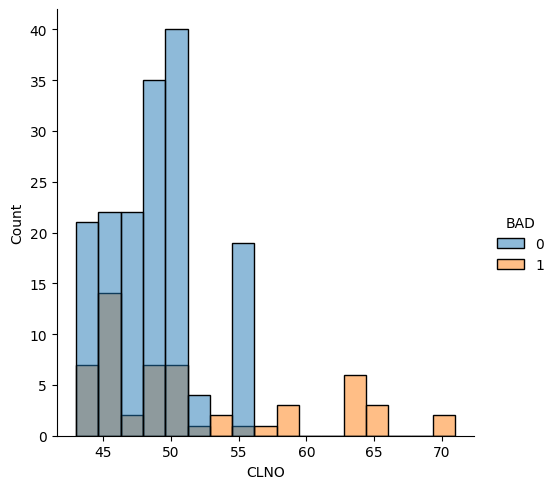

In [40]:
c = df[df['CLNO'] > 42]
sns.displot(c, x='CLNO', hue = 'BAD')

### Nombre de demandes de nouveaux crédits NINQ / BAD

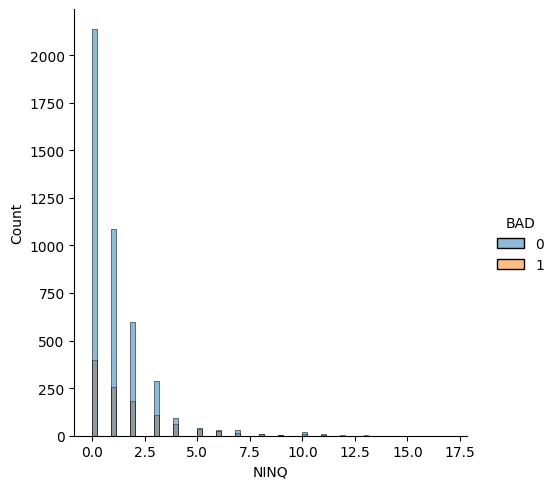

In [41]:
sns.displot(df, x= 'NINQ', hue = 'BAD')

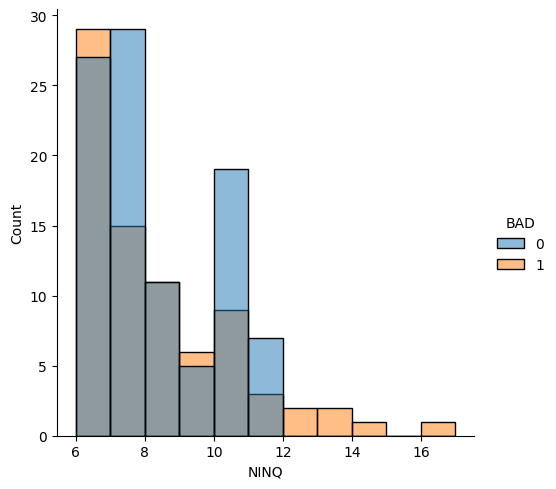

In [42]:
c = df[df['NINQ'] > 5]
sns.displot(c, x='NINQ', hue = 'BAD')

In [43]:
import pandas as pd
values_for_bad_1 = df[df['BAD'] == 1]['NINQ'].unique()
values_for_bad_0 = df[df['BAD'] == 0]['NINQ'].unique()
values_only_with_bad_1 = [value for value in values_for_bad_1 if value not in values_for_bad_0]
print("Valeurs de NINQ pour lesquelles BAD est égal à 1:", values_for_bad_1)
print("Valeurs de NINQ pour lesquelles BAD est égal à 0:", values_for_bad_0)
print("Valeurs de NINQ pour lesquelles BAD est uniquement égal à 1:", values_only_with_bad_1)

Valeurs de NINQ pour lesquelles BAD est égal à 1: [ 1.  0. nan  2.  3.  5. 14. 10.  4.  8.  6. 11.  9.  7. 12. 17. 13.]
Valeurs de NINQ pour lesquelles BAD est égal à 0: [ 0. nan  1.  2.  3. 10.  4.  9.  8.  7.  5.  6. 11.]
Valeurs de NINQ pour lesquelles BAD est uniquement égal à 1: [nan, 14.0, 12.0, 17.0, 13.0]


On peut supposer que  si la personne a plus que 12 crédits elle est suceptible de tomber en en défaut.

### CLAGE, DEBTINQ / BAD

<ipython-input-44-9f37f2f417c5>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(default[col], ax=ax, label='en défaut')
<ipython-input-44-9f37f2f417c5>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(not_default[col], ax=ax, label='sain')
<ipython-input-44-9f37f2f417c5>:8: UserWarning: 

`dist

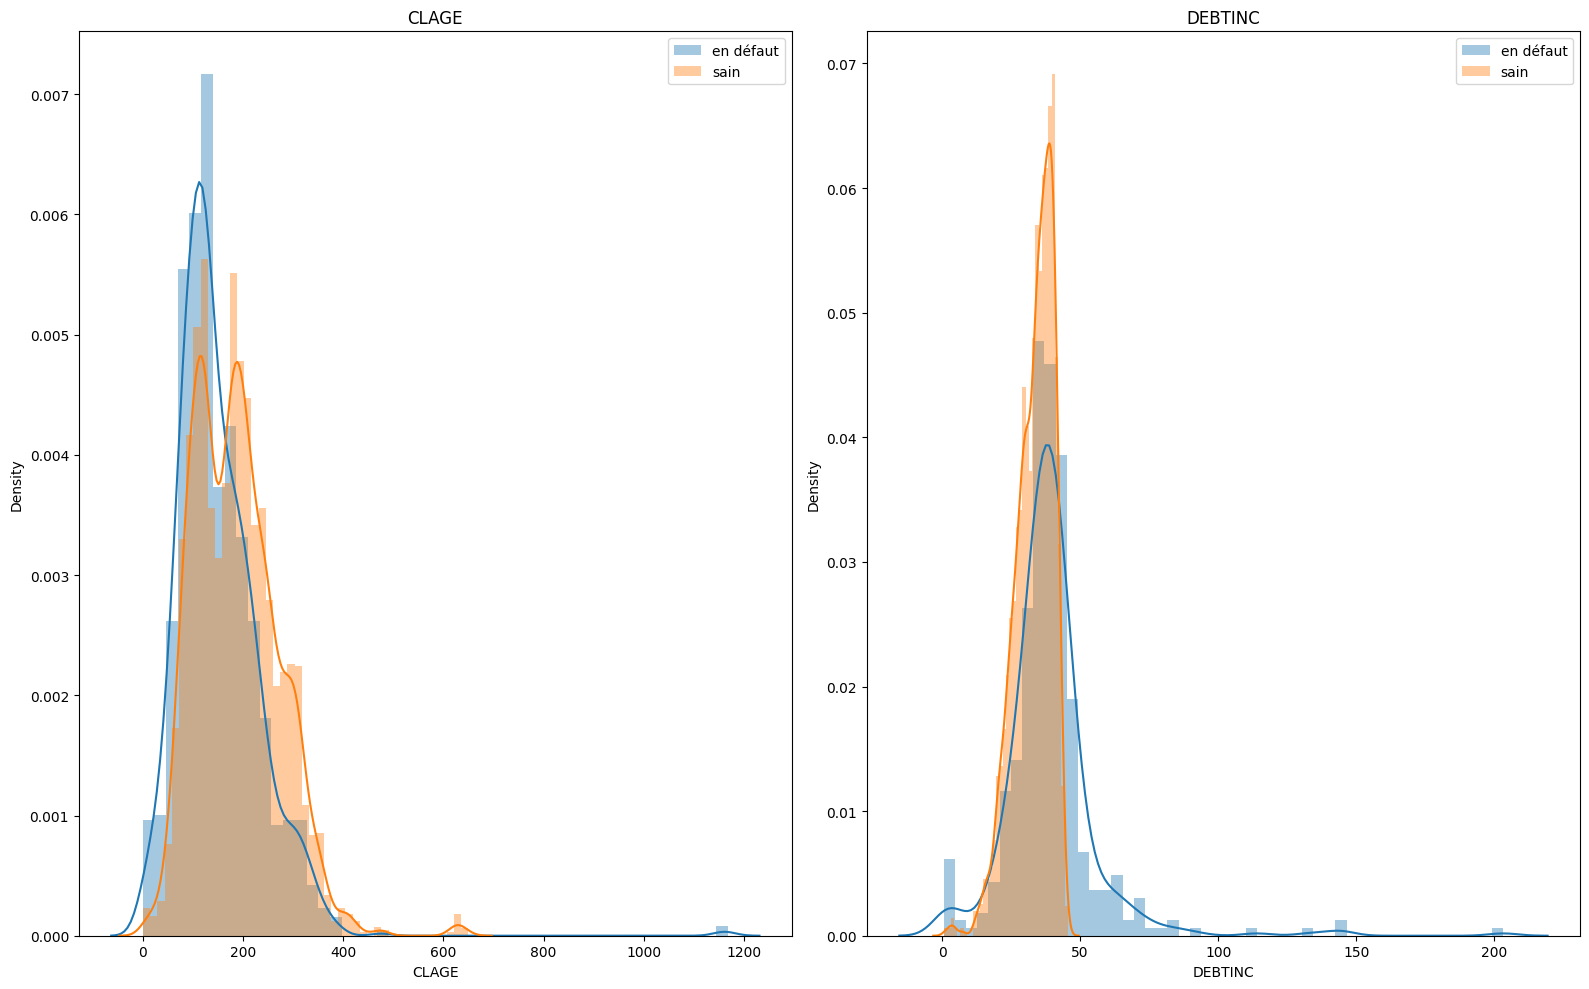

In [44]:
default=df[df['BAD']==1]
not_default=df[df['BAD']==0]
c = df[['CLAGE', 'DEBTINC']]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

for ax, col in zip(axs.flatten(),c ):
    sns.distplot(default[col], ax=ax, label='en défaut')
    sns.distplot(not_default[col], ax=ax, label='sain')
    ax.set(title=col)
    ax.legend()

plt.tight_layout()
plt.show()

On remarque des différences entre les distributions:
*   Pour CLAGE : age de la plus ancienne ligne de crédit , on remarque que pour un age entre 0 et 200 presque, il y a defaut.

*    Pour DEBTINQ: Ratio d’endettement: ratio 49 % => defaut

In [45]:
pd.crosstab(df['JOB'], df['NINQ'])

NINQ     0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0  \
JOB                                                                         
Mgr       303   166   115    35    25    27    12     9     4     1    12   
Office    450   226   123    72    22     5     0     0     0     0     0   
Other     966   536   337   181    56    23    30    28    16     9    13   
ProfExe   604   321   148    75    43    18     9     4     1     1     0   
Sales      68    23    11     1     0     0     2     3     0     0     0   
Self       62    35    35    25     2     2     3     0     1     0     0   

NINQ     11.0  12.0  13.0  14.0  17.0  
JOB                                    
Mgr         4     0     0     0     0  
Office      0     1     2     0     0  
Other       6     1     0     1     1  
ProfExe     0     0     0     0     0  
Sales       0     0     0     0     0  
Self        0     0     0     0     0

Les personnes qui travaillent dans les domaines de gestion mgr, other sont les plus suceptibles a avoir plus que 6 crédits

On remarque que le montant du pret immobilier(LOAN) suit une loi normale avec des valeurs abberrantes qui depassent les 4000 eur.

## Relation LOAN / JOB

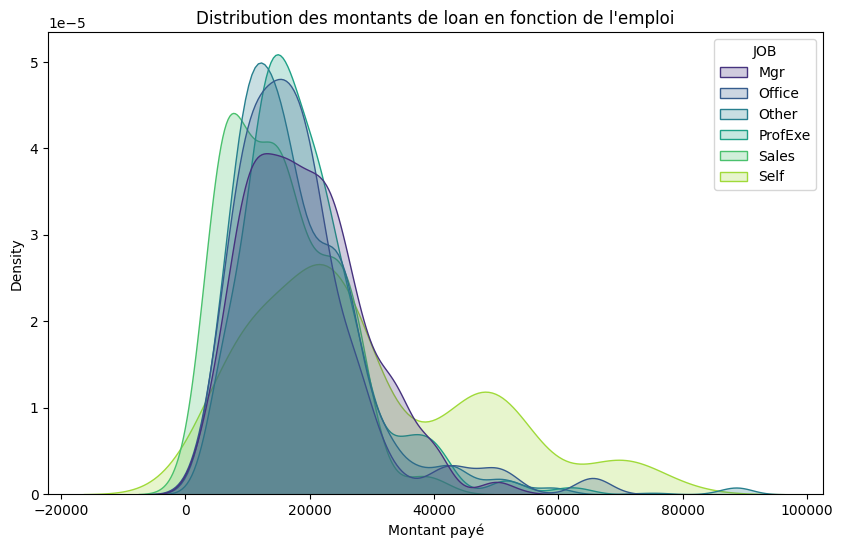

In [46]:
plt.figure(figsize=(10, 6))
sns.kdeplot(x='LOAN', hue='JOB', data=df, fill=True, common_norm=False, palette='viridis')
plt.title('Distribution des montants de loan en fonction de l\'emploi')
plt.xlabel('Montant payé')
plt.ylabel('Density')
plt.show()

## Relation LOAN / REASON

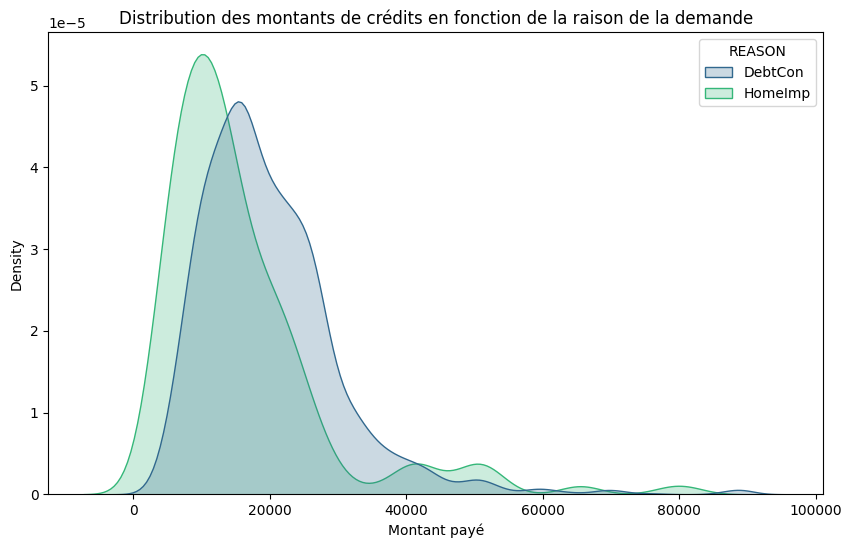

In [47]:
plt.figure(figsize=(10, 6))
sns.kdeplot(x='LOAN', hue='REASON', data=df, fill=True, common_norm=False, palette='viridis')
plt.title('Distribution des montants de crédits en fonction de la raison de la demande')
plt.xlabel('Montant payé')
plt.ylabel('Density')
plt.show()

## Relation YOJ / JOB

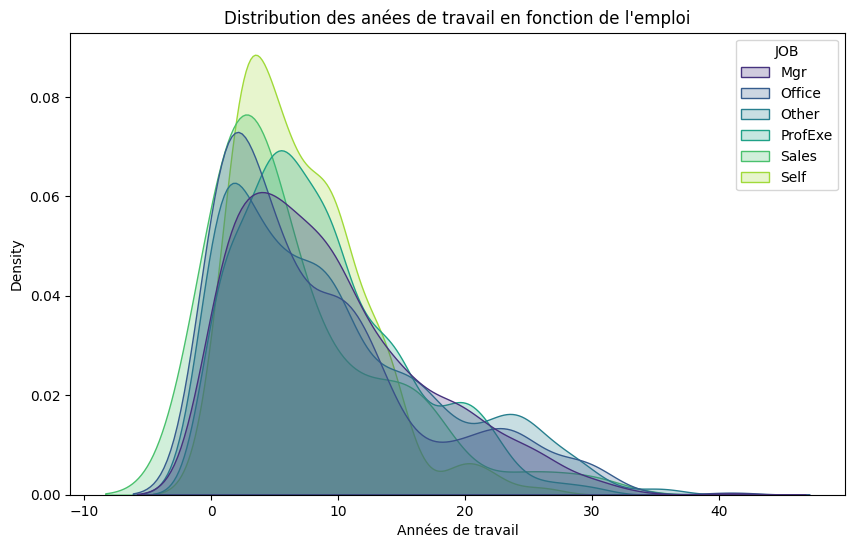

In [48]:
plt.figure(figsize=(10, 6))
sns.kdeplot(x='YOJ', hue='JOB', data=df, fill=True, common_norm=False, palette='viridis')
plt.title('Distribution des anées de travail en fonction de l\'emploi')
plt.xlabel('Années de travail')
plt.ylabel('Density')
plt.show()

## LOAN / MORTDUE / VALUE

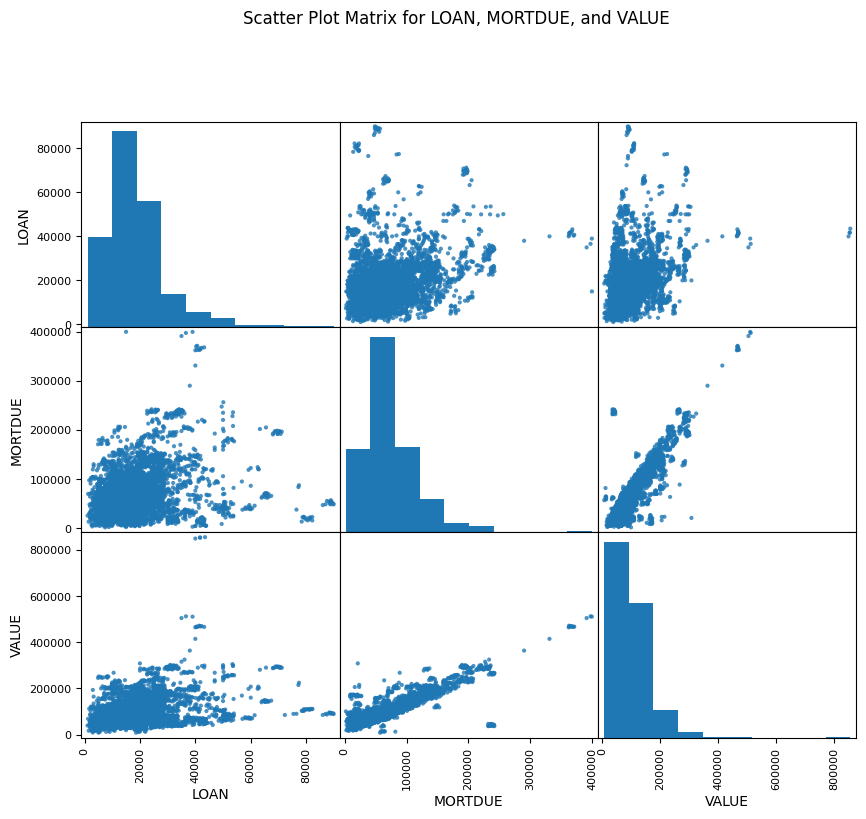

In [49]:
pd.plotting.scatter_matrix(df[['LOAN', 'MORTDUE', 'VALUE']], alpha=0.8, figsize=(10, 8), diagonal='hist')
plt.suptitle('Scatter Plot Matrix for LOAN, MORTDUE, and VALUE', y=1.02)
plt.show()

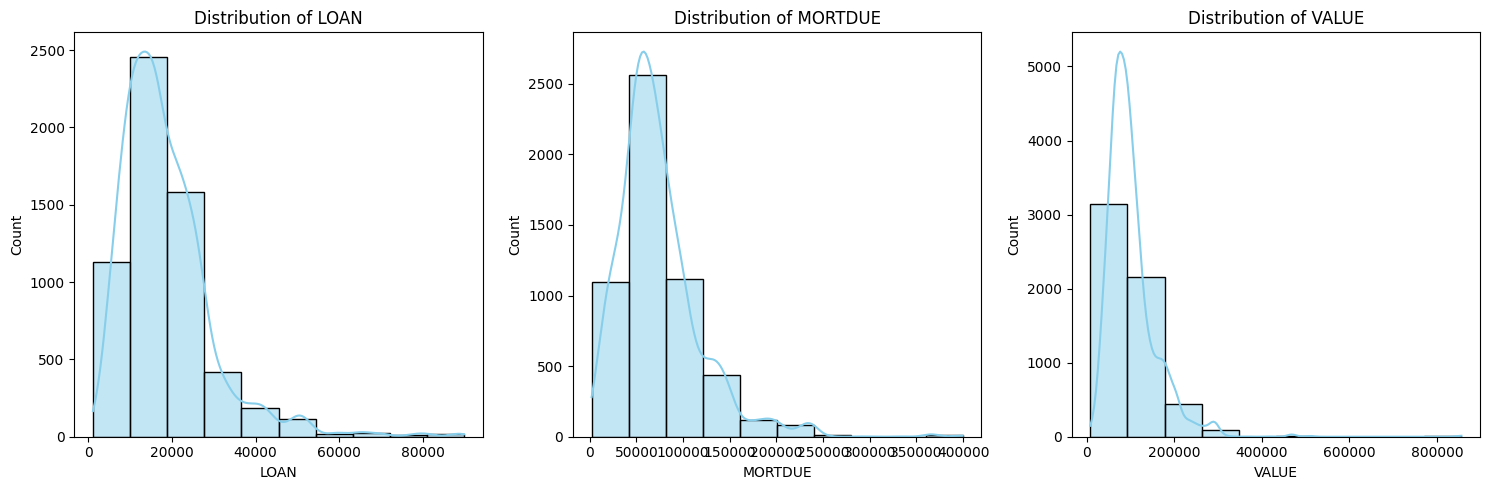

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot histograms for each variable
for i, col in enumerate(df[['LOAN', 'MORTDUE', 'VALUE']].columns):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue', bins=10)
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

Skewed distributions

## Les valeurs aberrantes

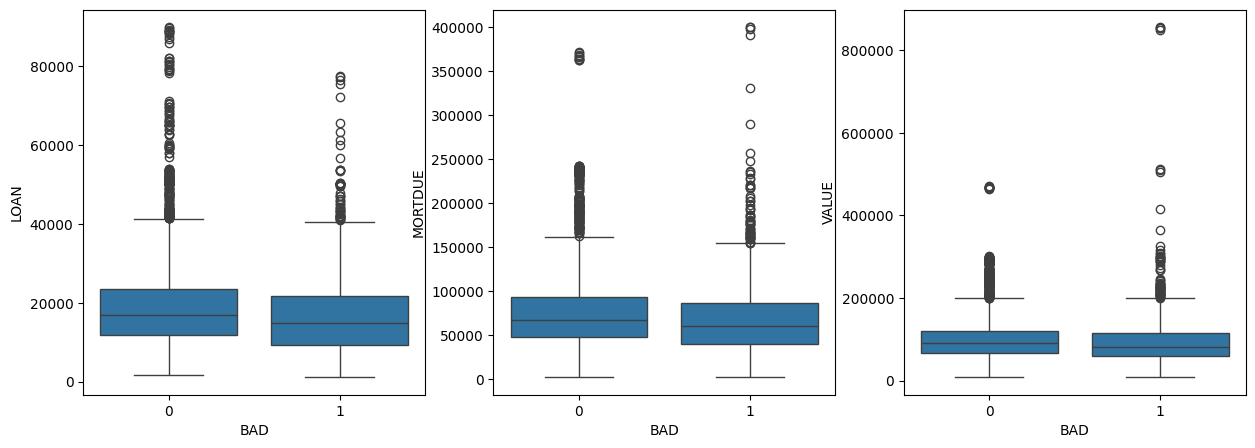

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='BAD', y='LOAN', data=df)
plt.subplot(1, 3, 2)
sns.boxplot(x='BAD', y='MORTDUE', data=df)
plt.subplot(1, 3, 3)
sns.boxplot(x='BAD', y='VALUE', data=df)
plt.show()

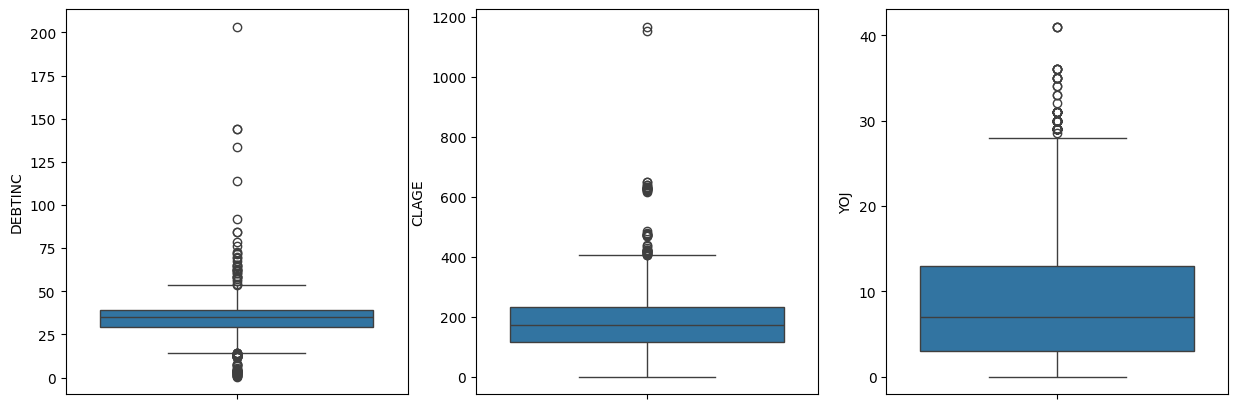

In [52]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(df["DEBTINC"])

plt.subplot(1, 3, 2)
sns.boxplot(df["CLAGE"])

plt.subplot(1, 3, 3)
sns.boxplot(df["YOJ"])

plt.show()

In [53]:
#pourcentage des outliers
def count_outliers(df,column):
    Q1=df[column].describe()['25%']
    Q3=df[column].describe()['75%']
    IQR=Q3-Q1
    max=Q3+1.5*IQR
    min=Q1-1.5*IQR
    print(f'low outliers percentage in variable {column} : {round(df[df[column]<min].shape[0]/df.shape[0],2)*100}% and high outliers percentage in variable {column}:{round(df[df[column]>max].shape[0]/df.shape[0],2)*100}%\n')

#Comptage des outliers dans tous le dataset
for column in df_numerical.columns:
    count_outliers(df,column)


low outliers percentage in variable LOAN : 0.0% and high outliers percentage in variable LOAN:4.0%

low outliers percentage in variable MORTDUE : 0.0% and high outliers percentage in variable MORTDUE:4.0%

low outliers percentage in variable VALUE : 0.0% and high outliers percentage in variable VALUE:5.0%

low outliers percentage in variable YOJ : 0.0% and high outliers percentage in variable YOJ:2.0%

low outliers percentage in variable DEROG : 0.0% and high outliers percentage in variable DEROG:12.0%

low outliers percentage in variable DELINQ : 0.0% and high outliers percentage in variable DELINQ:20.0%

low outliers percentage in variable CLAGE : 0.0% and high outliers percentage in variable CLAGE:1.0%

low outliers percentage in variable NINQ : 0.0% and high outliers percentage in variable NINQ:3.0%

low outliers percentage in variable CLNO : 0.0% and high outliers percentage in variable CLNO:4.0%

low outliers percentage in variable DEBTINC : 1.0% and high outliers percentage in v

# **Tests Statistiques**

## Test de cramer entre les variables catégorielles

In [54]:
job_reason = pd.crosstab(df['JOB'],df['REASON'])

In [55]:
job_reason

REASON   DebtCon  HomeImp
JOB                      
Mgr          572      174
Office       620      301
Other       1604      716
ProfExe      847      405
Sales         97       12
Self          73      115

In [56]:
# Effectuer le test du chi-deux
chi2, p, dof, expected = chi2_contingency(job_reason)
n = len(df)
k = len(df['JOB'].unique())
r = len(df['REASON'].unique())
cramer_v = np.sqrt(chi2 / (n * min(k - 1, r - 1)))

print(f"Test du Chi-deux : chi2 = {chi2}, p-value = {p}")
print(f"Valeur de Cramer : {cramer_v}")

Test du Chi-deux : chi2 = 122.90857547157839, p-value = 7.594351096848582e-25
Valeur de Cramer : 0.10154369553704619


La valeur de cramer est autour de 0.1 et donc la relation entre Job et Reason est faible. Il semble y avoir une association significative entre les deux variables, mais cette association n'est pas extrêmement forte.

## Test de chi2 entre la cible et les variables catégorielles

In [57]:
reason_bad = pd.crosstab(df['BAD'], df['REASON'])

# Perform Chi-Square test
chi2_value, p_value,_ ,_= chi2_contingency(reason_bad)

n = len(df)
k = len(df['BAD'].unique())
r = len(df['REASON'].unique())
cramer_v = np.sqrt(chi2_value / (n * min(k - 1, r - 1)))

print(f"chi2_value: {chi2_value} et p_value: {p_value}")
print(f"Valeur de Cramer : {cramer_v}")
#p-value est faible (<0.001) donc on rejette l'hypothèse nulle au seuil de 1% , les variables REASON et BAD sont dépendantes l'une de l'autre.

chi2_value: 8.039751291499368 et p_value: 0.004576181950707231
Valeur de Cramer : 0.0367280758953747


In [58]:
reason_bad = pd.crosstab(df['BAD'], df['JOB'])

# Perform Chi-Square test
chi2_value, p_value,_ ,_= chi2_contingency(reason_bad)

n = len(df)
k = len(df['BAD'].unique())
r = len(df['JOB'].unique())
cramer_v = np.sqrt(chi2_value / (n * min(k - 1, r - 1)))

print(f"chi2_value: {chi2_value} et p_value: {p_value}")
print(f"Valeur de Cramer : {cramer_v}")
#p-value est faible (<0.001) donc on rejette l'hypothèse nulle au seuil de 1% , les variables REASON et BAD sont dépendantes l'une de l'autre.

chi2_value: 81.93248953692775 et p_value: 3.3066762328584986e-16
Valeur de Cramer : 0.11724786566432766


## Régression linéaire entre Value et Mortdue

In [59]:
#On peut effectuer un modèle de régression entre value et mortdue
# (puisqu'on a trouvé un coeff de corrélation très élevé) pour savoir si on peut prédire mortdue à partir de value?

y = df['MORTDUE']


x = df["VALUE"]


x = sm.add_constant(x)


model = sm.OLS(y, x, missing='drop' ).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                MORTDUE   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                 1.761e+04
Date:                Sun, 18 Feb 2024   Prob (F-statistic):               0.00
Time:                        00:25:06   Log-Likelihood:                -61001.
No. Observations:                5357   AIC:                         1.220e+05
Df Residuals:                    5355   BIC:                         1.220e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1280.4134    636.292     -2.012      0.0

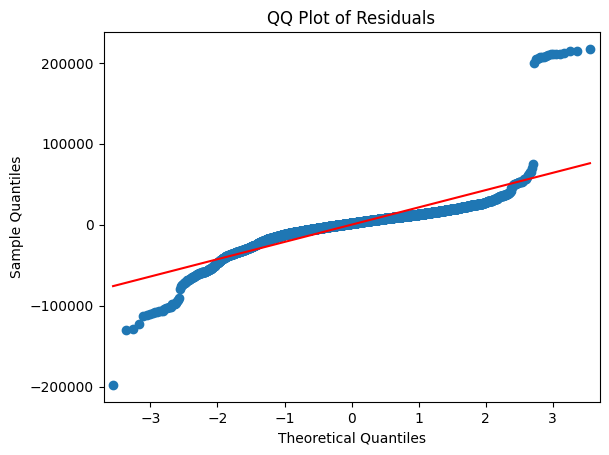

In [60]:
##QQplot
residuals = model.resid

# Create QQ plot
sm.qqplot(residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.show()


## ANOVA

In [61]:
#Regardons la relation entre LOAN et les groupes de JOB en suite groupe de REASON

import pandas as pd
from scipy.stats import f_oneway

# Chargeons nos données
# Sélectionnons les colonnes pertinentes
df_anova = df[['LOAN', 'JOB', 'REASON']].dropna()

# Effectuons l'ANOVA pour la variable 'LOAN' en fonction de 'JOB'
result_job = f_oneway(*[df_anova['LOAN'][df_anova['JOB'] == job] for job in df_anova['JOB'].unique()])

# Effectuons l'ANOVA pour la variable 'LOAN' en fonction de 'REASON'
result_reason = f_oneway(*[df_anova['LOAN'][df_anova['REASON'] == reason] for reason in df_anova['REASON'].unique()])

# Affichons les résultats
print("ANOVA pour la variable 'LOAN' en fonction de 'JOB':")
print(f"Statistique F : {result_job.statistic}")
print(f"Valeur p : {result_job.pvalue}")

print("\nANOVA pour la variable 'LOAN' en fonction de 'REASON':")
print(f"Statistique F : {result_reason.statistic}")
print(f"Valeur p : {result_reason.pvalue}")

ANOVA pour la variable 'LOAN' en fonction de 'JOB':
Statistique F : 34.799014681823
Valeur p : 3.7399206079250787e-35

ANOVA pour la variable 'LOAN' en fonction de 'REASON':
Statistique F : 220.02285501515465
Valeur p : 7.676687782467693e-49


***ANOVA pour la variable 'LOAN' et 'JOB':***
La statistique F est élevée (34.80), ce qui montre qu'il existe des différences significatives entre les moyennes de la variable 'LOAN' entre les différents niveaux de la variable 'JOB'.

La valeur p est très faible (3.74e-35), bien en dessous du seuil de signification de 0.05. Cela indique que nous pouvons rejeter l'hypothèse nulle selon laquelle toutes les moyennes de 'LOAN' sont égales entre les groupes de 'JOB'. Donc il semble y avoir des différences significatives dans les montants de prêts ('LOAN') entre les différents types d'emploi ('JOB').

***ANOVA pour la variable 'LOAN' en fonction de 'REASON':***
La statistique F est élevée (220.02), indiquant des différences significatives entre les moyennes de la variable 'LOAN' entre les différents niveaux de la variable 'REASON'.

La valeur p est très faible (7.68e-49), bien en dessous de 0.05. Cela montre que nous pouvons rejeter l'hypothèse nulle selon laquelle toutes les moyennes de 'LOAN' sont égales entre les groupes de 'REASON'
**Les résultats suggèrent que les variables 'JOB' et 'REASON' ont un impact significatif sur la moyenne des montants de prêts ('LOAN')**

In [62]:
#Regardons la relation entre YOJ et les groupes de JOB
import pandas as pd
from scipy.stats import f_oneway

# Chargeons los données
# Sélectionnons les colonnes pertinentes
df_anova_yoj = df[['YOJ', 'JOB']].dropna()

# Effectuons l'ANOVA pour la variable 'YOJ' en fonction de 'JOB'
result_yoj_job = f_oneway(*[df_anova_yoj['YOJ'][df_anova_yoj['JOB'] == job] for job in df_anova_yoj['JOB'].unique()])

# Affichons les résultats
print("ANOVA pour la variable 'YOJ' en fonction de 'JOB':")
print(f"Statistique F : {result_yoj_job.statistic}")
print(f"Valeur p : {result_yoj_job.pvalue}")

ANOVA pour la variable 'YOJ' en fonction de 'JOB':
Statistique F : 7.477126472850805
Valeur p : 5.302108179866946e-07


**Les résultats de l'ANOVA indiquent que la variable 'JOB' a un effet significatif sur la moyenne de 'YOJ'. La valeur p très faible suggère que les différences observées entre les niveaux de 'JOB' ne sont pas simplement le résultat du hasard, mais plutôt qu'il existe des différences statistiquement significatives entre les groupes en termes de moyenne de 'YOJ'.**

# **Traitement des valeurs manquantes**

In [63]:
print(df.shape[0])
print((df.isna().sum()).sort_values(ascending=True))

5960
BAD           0
LOAN          0
VALUE       112
CLNO        222
REASON      252
JOB         279
CLAGE       308
NINQ        510
YOJ         515
MORTDUE     518
DELINQ      580
DEROG       708
DEBTINC    1267
dtype: int64


<Axes: >

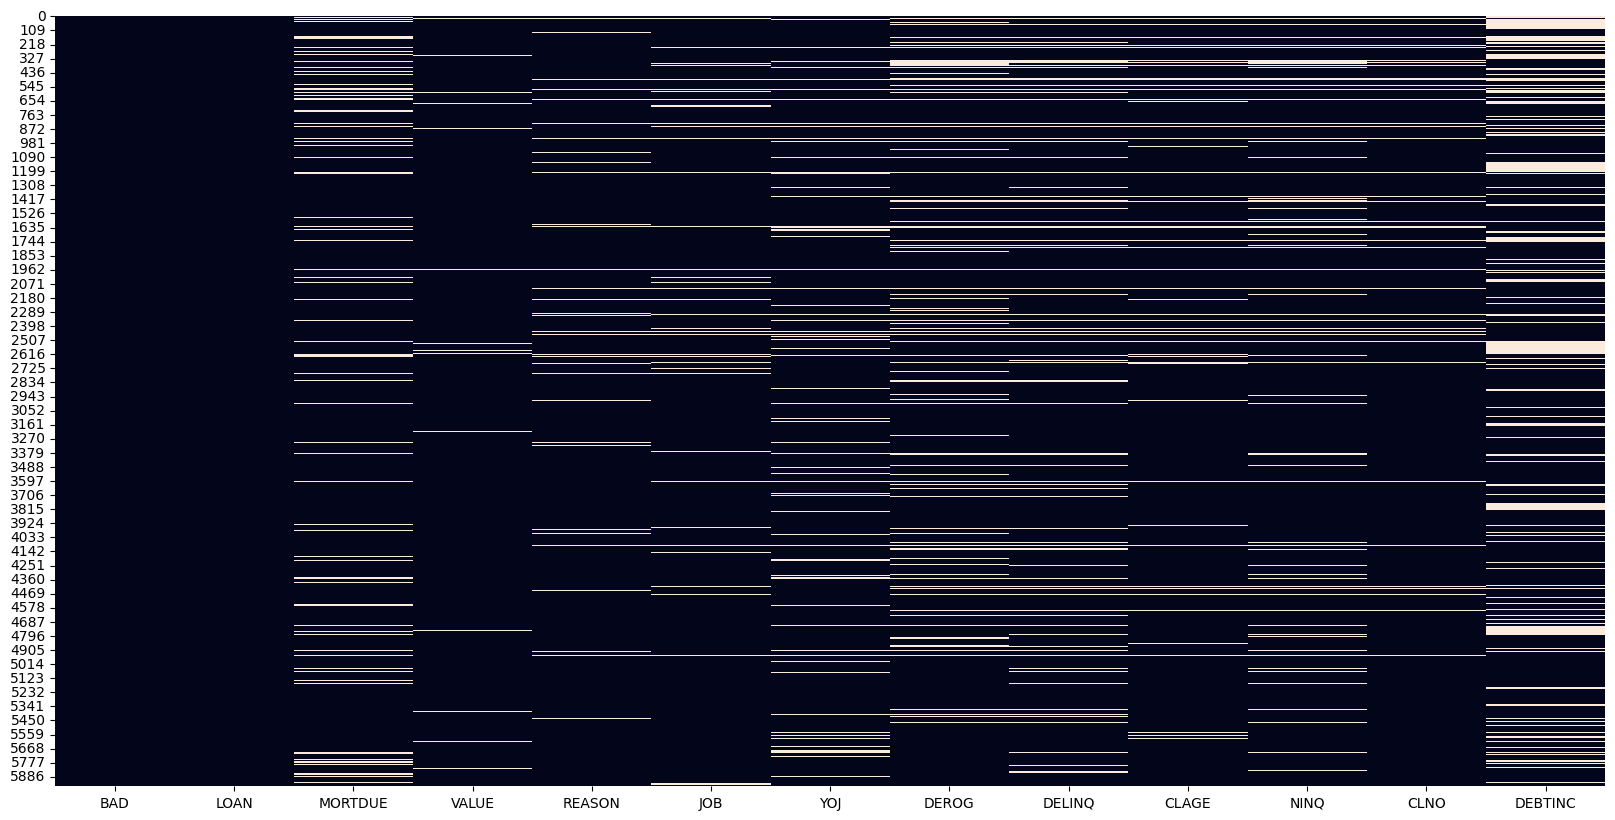

In [64]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(),cbar=False)

## Supprimer les observations avec au moins 4 valeurs manquantes

In [65]:
missing_values_count = df.isnull().sum(axis=1)
rows_with_more_than_4_missing = df[missing_values_count > 4]
len(rows_with_more_than_4_missing)

275

In [66]:
np.linspace(0.001,100, 20)

array([1.00000000e-03, 5.26410526e+00, 1.05272105e+01, 1.57903158e+01,
       2.10534211e+01, 2.63165263e+01, 3.15796316e+01, 3.68427368e+01,
       4.21058421e+01, 4.73689474e+01, 5.26320526e+01, 5.78951579e+01,
       6.31582632e+01, 6.84213684e+01, 7.36844737e+01, 7.89475789e+01,
       8.42106842e+01, 8.94737895e+01, 9.47368947e+01, 1.00000000e+02])

In [67]:
df = df.dropna(thresh=df.shape[1] - 4)

In [68]:
((df.isna().sum()).sort_values(ascending=True))

BAD           0
LOAN          0
CLNO          0
CLAGE        84
VALUE        89
JOB         145
REASON      164
NINQ        240
DELINQ      308
YOJ         352
MORTDUE     385
DEROG       437
DEBTINC    1196
dtype: int64

on observe que la variable CLNO ne présente plus de valeurs manquantes

## Imputer les variables catégorielles par le mode


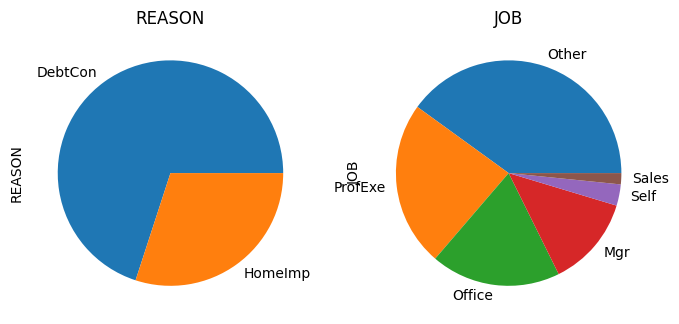

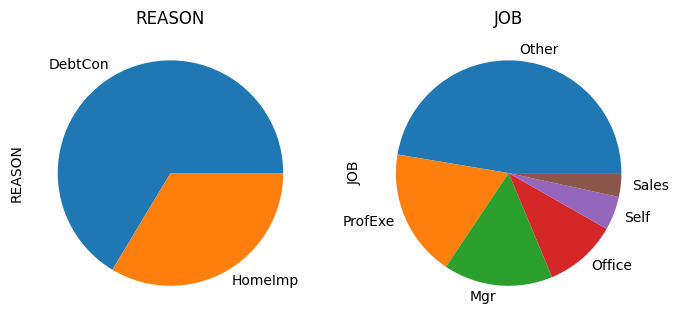

In [69]:
df_bad_0 = df[df['BAD'] == 0]
df_bad_1 = df[df['BAD'] == 1]
for data in [df_bad_0,df_bad_1]:
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
  cat_vars = [col for col in data.select_dtypes('category')]
  for ax, var in zip(axs.flatten(), cat_vars):
      data[var].value_counts().plot.pie(ax=ax)
      ax.set(title=var)
  plt.show()

In [70]:
# Calcul du mode de la variable 'JOB' et remplacement des valeurs manquantes par ce mode
mode_job = df['JOB'].mode()[0]
df['JOB'].fillna(mode_job, inplace=True)

# Calcul du mode de la variable 'REASON' et remplacement des valeurs manquantes par ce mode
mode_reason = df['REASON'].mode()[0]
df['REASON'].fillna(mode_reason, inplace=True)

# Affichage du nombre de valeurs manquantes pour chaque variable, triées par ordre croissant
((df.isna().sum()).sort_values(ascending=True))

<ipython-input-70-ce148c2c6b70>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['JOB'].fillna(mode_job, inplace=True)
<ipython-input-70-ce148c2c6b70>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['REASON'].fillna(mode_reason, inplace=True)


BAD           0
LOAN          0
REASON        0
JOB           0
CLNO          0
CLAGE        84
VALUE        89
NINQ        240
DELINQ      308
YOJ         352
MORTDUE     385
DEROG       437
DEBTINC    1196
dtype: int64

## Imputation de DEBTINQ par la médiane

<Axes: xlabel='BAD', ylabel='DEBTINC'>

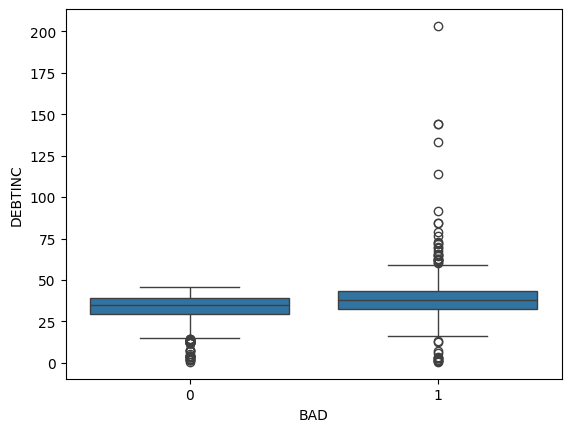

In [71]:
sns.boxplot(x='BAD', y='DEBTINC', data=df)

la distrubtution des données est skewed. Il existe plusieurs ou un grand nombre
de points de données qui agissent comme des valeurs aberrantes. Les points de données aberrants auront un impact significatif sur la moyenne et par conséquent, dans de tels cas, il n'est pas recommandé d'utiliser la moyenne pour remplacer les valeurs manquantes. Le choix de la médiane est plus judicieux

In [72]:
# Calcul de la médiane pour la variable 'DEBTINC'
median_DEBTINC = df['DEBTINC'].median()

def impute_DEBTINC(row):
    if pd.isnull(row['DEBTINC']):
        return median_DEBTINC
    else:
        return row['DEBTINC']

df['DEBTINC'] = df.apply(impute_DEBTINC, axis=1)


<ipython-input-72-ec6fd6034829>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DEBTINC'] = df.apply(impute_DEBTINC, axis=1)


In [73]:
((df.isna().sum()).sort_values(ascending=True))

BAD          0
LOAN         0
REASON       0
JOB          0
CLNO         0
DEBTINC      0
CLAGE       84
VALUE       89
NINQ       240
DELINQ     308
YOJ        352
MORTDUE    385
DEROG      437
dtype: int64

## Remplacer les données manquantes de DELINQ, DEROG, NINQ par le mode



In [74]:
columns_to_impute = ['DELINQ', 'DEROG', 'NINQ']  # Add more columns as needed

# calculer mdiane
mode_by_column = df[columns_to_impute].mode()

def impute_missing(row, column_name):
    if pd.isnull(row[column_name]):
        return mode_by_column[column_name]
    else:
        return row[column_name]

for column in columns_to_impute:
    df[column] = df.apply(lambda row: impute_missing(row, column), axis=1)


<ipython-input-74-165be927ce19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df.apply(lambda row: impute_missing(row, column), axis=1)
<ipython-input-74-165be927ce19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df.apply(lambda row: impute_missing(row, column), axis=1)
<ipython-input-74-165be927ce19>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [75]:
((df.isna().sum()).sort_values(ascending=True))

BAD          0
LOAN         0
REASON       0
JOB          0
DEROG        0
DELINQ       0
NINQ         0
CLNO         0
DEBTINC      0
CLAGE       84
VALUE       89
YOJ        352
MORTDUE    385
dtype: int64

## Années de travail YOJ

<Axes: xlabel='JOB', ylabel='YOJ'>

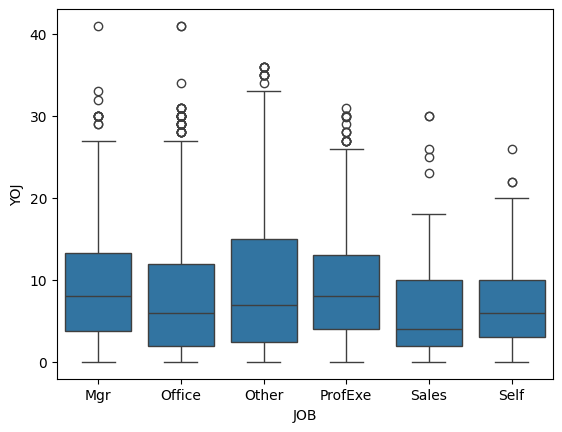

In [76]:
sns.boxplot(x='JOB', y='YOJ', data=df)

In [77]:
# Calculer la médiane pour 'YOJ' groupée par 'JOB'
median_by_yearsinjob = df.groupby('JOB')['YOJ'].median()
# Imputer les valeurs manquantes dans 'YOJ' en utilisant la médiane par 'JOB'
df['YOJ'] = df.apply(lambda x: median_by_yearsinjob[x['JOB']] if pd.isnull(x['YOJ']) else x['YOJ'], axis=1)

<ipython-input-77-5898f9a09fd1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['YOJ'] = df.apply(lambda x: median_by_yearsinjob[x['JOB']] if pd.isnull(x['YOJ']) else x['YOJ'], axis=1)


In [78]:
((df.isna().sum()).sort_values(ascending=True))

BAD          0
LOAN         0
REASON       0
JOB          0
YOJ          0
DEROG        0
DELINQ       0
NINQ         0
CLNO         0
DEBTINC      0
CLAGE       84
VALUE       89
MORTDUE    385
dtype: int64

## Le reste des colonnes avec valeurs manquantes

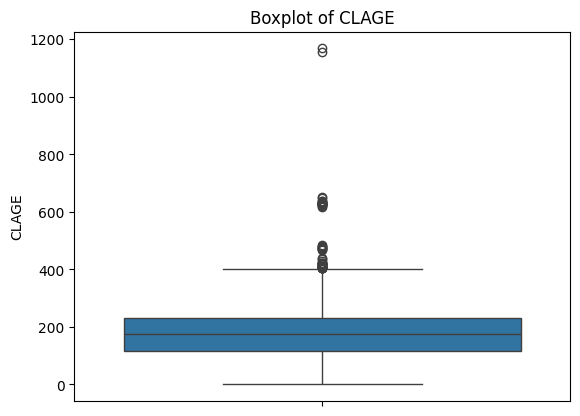

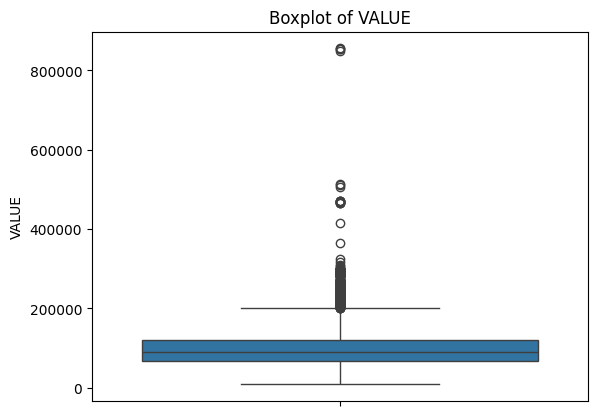

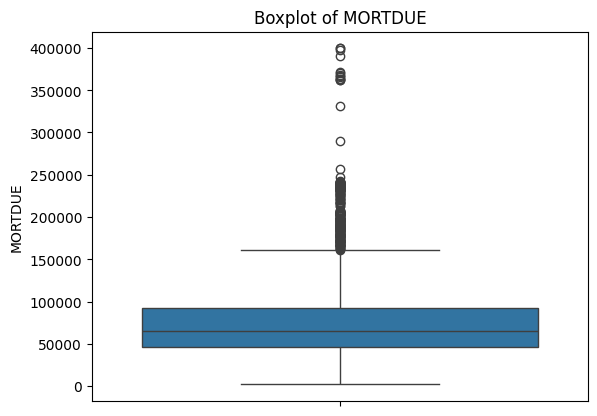

In [79]:
#box plot pour tous les colonnes avec missing values
numerical_columns= df[['CLAGE', 'VALUE', 'MORTDUE']]
for column in numerical_columns:
    sns.boxplot(df[column])
    plt.title(f"Boxplot of {column}")
    plt.show()

In [80]:
columns_to_impute = ['MORTDUE', 'CLAGE', 'VALUE']

median_by_column = df[columns_to_impute].median()

def impute_missing(row, column_name):
    if pd.isnull(row[column_name]):
        return median_by_column[column_name]
    else:
        return row[column_name]

for column in columns_to_impute:
    df[column] = df.apply(lambda row: impute_missing(row, column), axis=1)


<ipython-input-80-935f164b1ed5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df.apply(lambda row: impute_missing(row, column), axis=1)
<ipython-input-80-935f164b1ed5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df.apply(lambda row: impute_missing(row, column), axis=1)
<ipython-input-80-935f164b1ed5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [81]:
((df.isna().sum()).sort_values(ascending=True))

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

# **Comparaison de Modèles**

La métrique que nous avons choisi pour évaluer nos modèles est le recall, c'est  la capacité du modèle à identifier correctement tous les exemples positifs (personnes en défaut) parmi tous les exemples réellement positifs.
En effet, dans le domaine du risque du crédit, prédire incorrectement qu'un individu est en bonne santé financière alors qu'il est en défaut est dangereux et pourrait entraîner des pertes importantes pour la banque.

In [82]:
X = df.drop('BAD', axis=1)
y = df['BAD']

### Encoding des variables catégorielles

Encoder les variables catégorielles, c’est-à-dire transformer ces variables en un format numérique adapté à l’entrée des modèles de prédiction qui nécessitent des données numériques. Pour chaque modalité dans les colonnes des variables catégorielles, la fonction a créé une nouvelle colonne binaire (0 ou
1)

In [83]:
X_encoded = pd.get_dummies(X, columns=['REASON', 'JOB'], drop_first=True)
X_encoded

LOAN  MORTDUE     VALUE   YOJ DEROG DELINQ       CLAGE NINQ  CLNO  \
0      1100.0  25860.0   39025.0  10.5   0.0    0.0   94.366667  1.0   9.0   
1      1300.0  70053.0   68400.0   7.0   0.0    2.0  121.833333  0.0  14.0   
2      1500.0  13500.0   16700.0   4.0   0.0    0.0  149.466667  1.0  10.0   
4      1700.0  97800.0  112000.0   3.0   0.0    0.0   93.333333  0.0  14.0   
5      1700.0  30548.0   40320.0   9.0   0.0    0.0  101.466002  1.0   8.0   
...       ...      ...       ...   ...   ...    ...         ...  ...   ...   
5955  88900.0  57264.0   90185.0  16.0   0.0    0.0  221.808718  0.0  16.0   
5956  89000.0  54576.0   92937.0  16.0   0.0    0.0  208.692070  0.0  15.0   
5957  89200.0  54045.0   92924.0  15.0   0.0    0.0  212.279697  0.0  15.0   
5958  89800.0  50370.0   91861.0  14.0   0.0    0.0  213.892709  0.0  16.0   
5959  89900.0  48811.0   88934.0  15.0   0.0    0.0  219.601002  0.0  16.0   

        DEBTINC  REASON_HomeImp  JOB_Office  JOB_Other  JOB_ProfExe  \
0     34.975655               1           0          1            0   
1     34.975655               1           0          1            0   
2     34.975655               1           0          1            0   
4     34.975655               1           1          0            0   
5     37.113614               1           0          1            0   
...         ...             ...         ...        ...          ...   
5955  36.112347               0           0          1            0   
5956  35.859971               0           0          1            0   
5957  35.556590               0           0          1            0   
5958  34.340882               0           0          1            0   
5959  34.571519               0           0          1            0   

      JOB_Sales  JOB_Self  
0             0         0  
1             0         0  
2             0         0  
4             0         0  
5             0         0  
...         ...       ...  
5955          0         0  
5956          0         0  
5957          0         0  
5958          0         0  
5959          0         0  

[5685 rows x 16 columns]

In [84]:
#separation en test et apprentissage
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42,stratify=y)

### La mise à l’échelle robuste



In [85]:
columns_to_scale = ['CLAGE', 'DEBTINC', 'VALUE', 'MORTDUE', 'LOAN']
scaler = RobustScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

RobustScaler est une technique de prétraitement de données utilisée dans l'apprentissage automatique pour mettre à l'échelle les caractéristiques numériques tout en gérant efficacement les valeurs aberrantes. Contrairement à StandardScaler et MinMaxScaler, RobustScaler est conçu pour résister à l'influence des valeurs aberrantes dans les données.

Il met à l'échelle les caractéristiques en utilisant la médiane et l'intervalle interquartile (IQR) au lieu de la moyenne et de l'écart type, ce qui le rend robuste à la présence de valeurs extrêmes.

In [86]:
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

## **Régression Logistique**

### **Modèle classique**

In [87]:
# Initialiser le modèle de régression logistique

logistic_regression=LogisticRegression()
#entrainer le modele
logistic_regression.fit(X_train,y_train)

# Prédire les étiquettes sur l'ensemble d'entraînement
y_train_pred=logistic_regression.predict(X_train)
# Prédire les étiquettes sur l'ensemble de test
y_test_pred = logistic_regression.predict(X_test)

print(" Train Recall score:", recall_score(y_train, y_train_pred))
print(" Test Recall score:", recall_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

 Train Recall score: 0.33812154696132596
 Test Recall score: 0.36283185840707965
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       911
           1       0.76      0.36      0.49       226

    accuracy                           0.85      1137
   macro avg       0.81      0.67      0.70      1137
weighted avg       0.84      0.85      0.83      1137



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [88]:
print("Train Balanced Accuracy Score:", balanced_accuracy_score(y_train, y_train_pred))
print("Test Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Balanced Accuracy Score: 0.6530025796843413
Test Balanced Accuracy Score: 0.6671458962726946
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       911
           1       0.76      0.36      0.49       226

    accuracy                           0.85      1137
   macro avg       0.81      0.67      0.70      1137
weighted avg       0.84      0.85      0.83      1137



**Fonction de traçage de la courve d'apprentissage**

In [89]:
def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring=make_scorer(recall_score, pos_label = 1), n_jobs=-1)

    # Calculer les moyennes et les écarts-types des scores d'apprentissage et de validation
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("recall")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


# appliquer sur le modele actuel
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
#plot_learning_curve(logistic_regression, X_train, y_train, cv=cv)

### **Pénalisation L1 (Lasso)**

In [90]:
lasso = LogisticRegression(penalty='l1',solver='liblinear') # Créer un modèle de régression logistique avec la pénalité L1 et le solveur 'liblinear'
lasso.fit(X_train,y_train) #entrainer

 # Prédire les étiquettes sur les données d'entraînement
y_train_pred = lasso.predict(X_train)
 # Prédire les étiquettes sur les données de test
y_test_pred = lasso.predict(X_test)

print("Train Recall score:", recall_score(y_train, y_train_pred))
print("Test Recall score:", recall_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Recall score: 0.33812154696132596
Test Recall score: 0.3584070796460177
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       911
           1       0.76      0.36      0.49       226

    accuracy                           0.85      1137
   macro avg       0.81      0.66      0.70      1137
weighted avg       0.84      0.85      0.83      1137



In [91]:
print("Train Balanced Accuracy score:", balanced_accuracy_score(y_train, y_train_pred))
print("Test Balanced Accuracy score:", balanced_accuracy_score(y_test, y_test_pred))
print(classification_report(y_test,y_test_pred))

Train Balanced Accuracy score: 0.653139829203968
Test Balanced Accuracy score: 0.6649335068921636
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       911
           1       0.76      0.36      0.49       226

    accuracy                           0.85      1137
   macro avg       0.81      0.66      0.70      1137
weighted avg       0.84      0.85      0.83      1137



In [92]:
lasso.coef_ #les coefficients des variables après le lasso

array([[-0.21504463, -0.15207764,  0.20107511, -0.01067841,  0.58921332,
         0.79360663, -0.63444695,  0.16910326, -0.01644003,  0.49110903,
         0.21109673, -0.65057287,  0.04381313, -0.00881893,  0.93992043,
         0.44196398]])

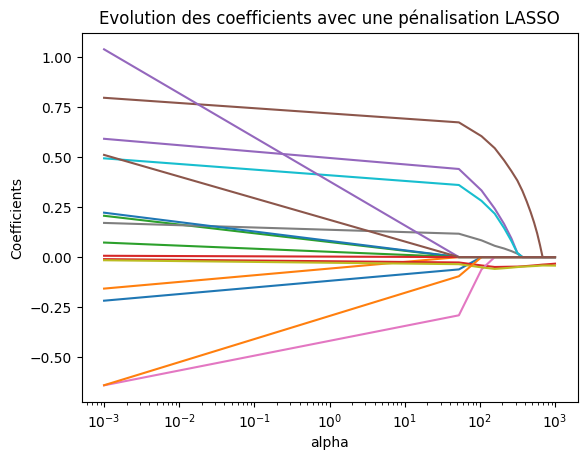

In [93]:
alphas = np.linspace(0.001, 1000, 20)  # Définition d'une séquence d'alphas
coefs = []  # Liste pour stocker les coefficients

# Parcours des différentes valeurs d'alpha
for alpha in alphas:
    lasso.set_params(C=1/alpha)  # Configuration du paramètre de régularisation C
    lasso.fit(X_train, y_train)  # Entraînement du modèle avec la nouvelle valeur d'alpha
    coefs.append(lasso.coef_[0])  # Ajout des coefficients à la liste

ax = plt.gca()  # Récupération de l'objet axe pour le tracé

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Evolution des coefficients avec une pénalisation LASSO')
plt.show()

<h2>Coefficient lambda optimal<h2>

In [94]:
# Définition d'une séquence d'alphas pour la recherche de grille
alphas = np.linspace(0, 0.2, 50)

# Définition de la grille des paramètres avec l'inverse des alphas pour le paramètre C
param_grid = {'C': 1/alphas}

# Initialisation de la recherche de grille
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='recall')

# Recherche des meilleurs hyperparamètres sur l'ensemble d'entraînement
grid_search.fit(X_train, y_train)

# Obtention de la meilleure valeur d'alpha
best_parameter = grid_search.best_params_['C']

print(f'Best parameter: {best_parameter} qui correspond à une valeur de alpha de {1/best_parameter}')

# Ajustement du modèle avec le meilleur alpha sur l'ensemble d'entraînement
final_model = LogisticRegression(penalty='l1', solver='liblinear', C=best_parameter)
final_model.fit(X_train, y_train)


y_pred = final_model.predict(X_test)

<ipython-input-94-f2d46419bcfe>:5: RuntimeWarning: divide by zero encountered in divide
  param_grid = {'C': 1/alphas}


Best parameter: 9.423076923076922 qui correspond à une valeur de alpha de 0.10612244897959186


In [95]:
best_model=grid_search.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)


print("train Recall:", recall_score(y_train, y_pred_train, pos_label=1))
print("test Recall:", recall_score(y_test, y_pred_test, pos_label=1))
print("train Balanced Accuracy score:", balanced_accuracy_score(y_train, y_pred_train))
print("test Balanced Accuracy score:", balanced_accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

train Recall: 0.3414364640883978
test Recall: 0.3584070796460177
train Balanced Accuracy score: 0.6547972877675039
test Balanced Accuracy score: 0.6638358120513294
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       911
           1       0.74      0.36      0.48       226

    accuracy                           0.85      1137
   macro avg       0.80      0.66      0.70      1137
weighted avg       0.84      0.85      0.83      1137



**la courbe d'apprentissage**

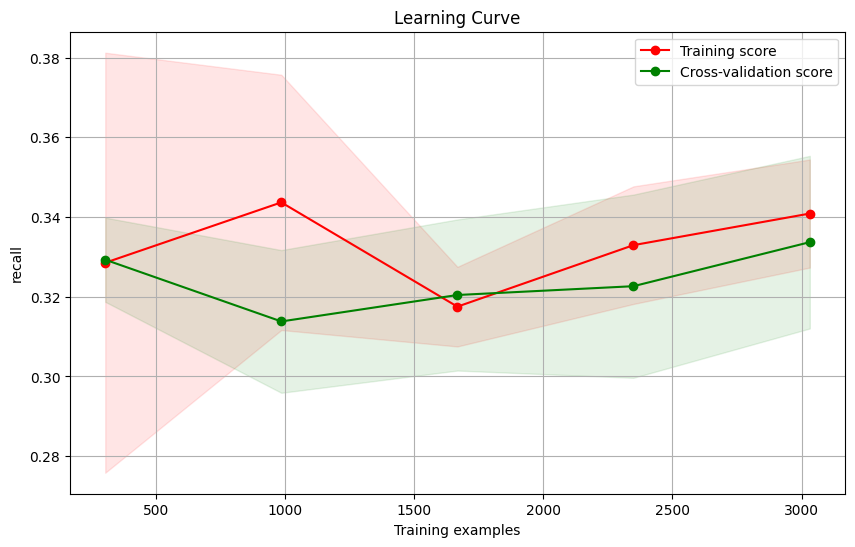

In [96]:
#tracer la courbe d'apprentissage
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(final_model, X_train, y_train, cv=cv)

<h2>Effet sur la performance<h2>

In [97]:
# Initialisation des listes pour stocker les résultats et les coefficients
res = []
coefs = []
# Définition des valeurs de lambda
lambda_values = np.linspace(0.001,1,20)

# Parcours des différentes valeurs de lambda
for alpha in tqdm(lambda_values):
    lasso = LogisticRegression(penalty='l1', C=1/alpha, solver='liblinear', random_state=42)

    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

    y_pred = lasso.predict(X_test)

    recall = recall_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    # Nombre de coefficients nuls dans le modèle
    num_null_coefficients = np.sum(lasso.coef_ == 0)

    res.append({'lambda': alpha, 'recall': recall, 'balanced accuracy': balanced_acc , 'nbnull': num_null_coefficients})

df = pd.DataFrame(res)

100%|██████████| 20/20 [00:01<00:00, 14.13it/s]


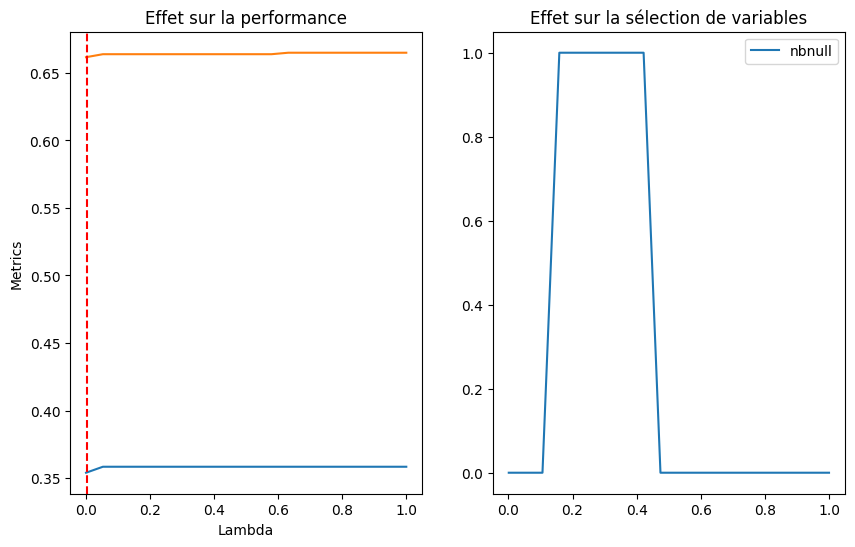

In [98]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(df['lambda'], df['recall'], label='Recall')
plt.plot(df['lambda'], df['balanced accuracy'], label='Balanced Accuracy')
plt.xlabel('Lambda')
plt.ylabel('Metrics')
plt.title('Effet sur la performance')
plt.axvline(x=0.004081632653061225, color='red', linestyle='--', label="Lambda = 0.004081632653061225")
plt.subplot(1, 2, 2)
plt.plot(df['lambda'], df['nbnull'], label='nbnull')
plt.title('Effet sur la sélection de variables')
plt.legend()
plt.show()

### **Pénalisation L2 (Ridge)**

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, classification_report

# Créons une instance de la régression logistique avec régularisation L2 (Ridge)
ridge_logistic_regression = LogisticRegression(penalty='l2',solver='lbfgs')

# Entraînons le modèle sur les données d'entraînement
ridge_logistic_regression.fit(X_train, y_train)

# Faisons des prédictions sur l'ensemble de test
y_pred_ridge = ridge_logistic_regression.predict(X_test)

# Évaluons les performances du modèle
print("balanced accuracy score (Ridge):", balanced_accuracy_score(y_test, y_pred_ridge))
print("recall score (Ridge):", recall_score(y_test, y_pred_ridge))
print("Classification Report (Ridge):\n", classification_report(y_test, y_pred_ridge))
#print("recall score (Ridge):", recall_score(y_test, y_pred_ridge))

La balanced accuracy score est d'environ 54.7%, ce qui peut indiquer que le modèle a des performances limitées, en particulier en tenant compte du déséquilibre entre les classes.
Recall pour la classe 1 est faible (11%), suggérant que le modèle a du mal à identifier correctement les instances de la classe 1.


<h2> Optimisation des hyperparmetres <h2>





In [100]:
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning


# Définissons la grille de recherche pour la régression logistique avec L2 (Ridge)
alphas = np.linspace(0,0.2, 50)
param_grid = {'C': 1/alphas,
              'solver': ['lbfgs', 'liblinear', 'sag', 'saga']
              }

ridge_logistic_regression = LogisticRegression(penalty='l2')

warnings.filterwarnings("ignore", category=ConvergenceWarning)

with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  # Utilisons GridSearchCV pour trouver le meilleur paramètre
  grid_search = GridSearchCV(ridge_logistic_regression, param_grid, cv=5, scoring='recall')
  grid_search.fit(X_train, y_train)

  # Obtenons le meilleur modèle
  best_model = grid_search.best_estimator_

  # Obtenons le meilleur paramètre
  best_parameter = grid_search.best_params_['C']
  print(f'Best parameter: {best_parameter} qui correspond à une valeur de alpha de {1/best_parameter}')

with warnings.catch_warnings():
  warnings.simplefilter("ignore")

  # Utilisons le meilleur modèle sur l'ensemble de test
  y_pred = best_model.predict(X_test)

  # Évaluons le modèle sur l'ensemble de test avec le rappel et la balanced accuracy
  recall = recall_score(y_test, y_pred)
  balanced_acc = balanced_accuracy_score(y_test, y_pred)

# Affichons les résultats
print(f'Recall on test set: {recall}')
print(f'Balanced Accuracy on test set: {balanced_acc}')
print("Classification Report (Ridge):\n", classification_report(y_test, y_pred_ridge))


On voit que notre score c'est un peu amélioré


**Courbe d'apprentissage**

In [101]:
# plot_learning_curve(best_model, X_train, y_train, cv=5)

## **Arbre de décision**

### **Modèle classique**



In [102]:
# Initialisation du classificateur arbre de décision

decision_tree = tree.DecisionTreeClassifier()
# Entraînement du modèle sur l'ensemble d'entraînement
decision_tree.fit(X_train, y_train)
#prediction
y_train_pred = decision_tree.predict(X_train)
y_test_pred = decision_tree.predict(X_test)

# Calcul du score de rappel sur les ensembles d'entraînement et de test
print("Train Recall score:", recall_score(y_train, y_train_pred)) # Calcul du score de rappel sur les ensembles d'entraînement
print("Test Recall score:", recall_score(y_test, y_test_pred)) # Calcul du score de rappel sur les ensembles de test

print(classification_report(y_test, y_test_pred))

Train Recall score: 1.0
Test Recall score: 0.7079646017699115
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       911
           1       0.70      0.71      0.70       226

    accuracy                           0.88      1137
   macro avg       0.81      0.82      0.81      1137
weighted avg       0.88      0.88      0.88      1137



In [103]:
#CALCUL DU BALANCED ACCURACY
print("Train Balanced Accuracy Score:", balanced_accuracy_score(y_train, y_train_pred))
print("Test Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Balanced Accuracy Score: 1.0
Test Balanced Accuracy Score: 0.815562981455757
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       911
           1       0.70      0.71      0.70       226

    accuracy                           0.88      1137
   macro avg       0.81      0.82      0.81      1137
weighted avg       0.88      0.88      0.88      1137



### Tuning des param**



In [104]:
# Définition de la grille des hyperparamètres

grid_param = {
    'max_depth': [None, 10, 20],  # Profondeur maximale de l'arbre
    'min_samples_split': [2, 5, 10],  # Nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_leaf': [1, 2, 4]  # Nombre minimum d'échantillons requis pour être à un nœud feuille
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # Définition de la validation croisée stratifiée avec 3 plis
grid_search=GridSearchCV(estimator=decision_tree,param_grid=grid_param,cv=cv,n_jobs=-1)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [105]:
print(grid_search.best_params_)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [106]:
# Récupération des meilleurs hyperparamètres trouvés
best_params = grid_search.best_params_
best_model = tree.DecisionTreeClassifier(random_state=42, **best_params) # Initialisation du meilleur modèle d'arbre de décision avec les meilleurs hyperparamètres
best_model.fit(X_train, y_train)

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

print("Train Balanced Accuracy Score:", balanced_accuracy_score(y_train, y_pred_train))
print("Test Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred_test))
print("Train recall Score:", recall_score(y_train, y_pred_train))
print("Test recall Score:", recall_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Train Balanced Accuracy Score: 0.8857225618494866
Test Balanced Accuracy Score: 0.8165756778022789
Train recall Score: 0.7988950276243094
Test recall Score: 0.6858407079646017
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       911
           1       0.76      0.69      0.72       226

    accuracy                           0.90      1137
   macro avg       0.84      0.82      0.83      1137
weighted avg       0.89      0.90      0.89      1137



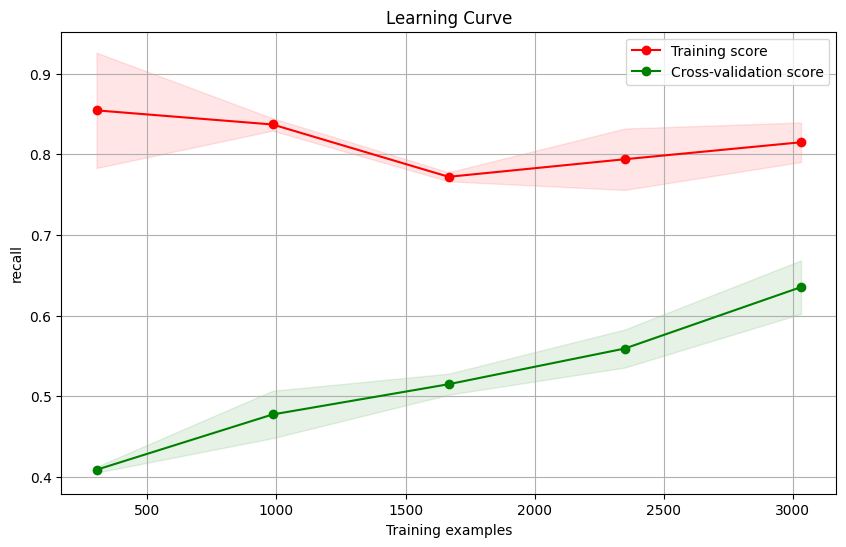

In [107]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(best_model, X_train, y_train, cv=3)

**l'importance des coefficients**

DEBTINC    0.490261
DELINQ     0.165129
CLAGE      0.067714
VALUE      0.053560
CLNO       0.040062
DEROG      0.033059
LOAN       0.032233
YOJ        0.031243
NINQ       0.029379
MORTDUE    0.029175
dtype: float64


<Axes: >

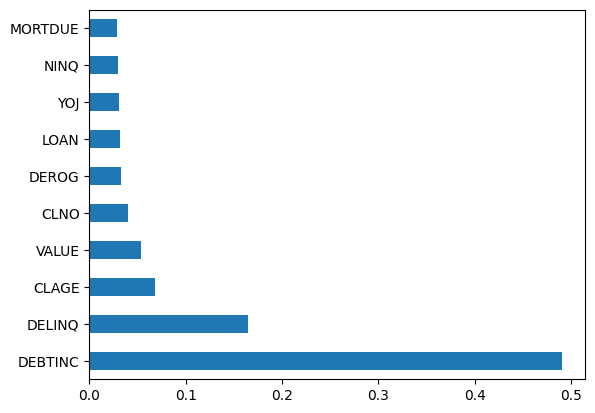

In [108]:
# Calcul de l'importance des coefficients du meilleur modèle
coefficients_importance=best_model.feature_importances_
#classer par ordre décroissant
coefficients_importance=pd.Series(coefficients_importance,index=X_train.columns.values).sort_values(ascending=False)[:10]
print(coefficients_importance)
coefficients_importance.plot(kind='barh')

## **Random Forest**

### **Modèle classique**

In [109]:
# Instanciation du modèle de forêt aléatoire avec 50 estimateurs et une random state de 42
random_forest = RandomForestClassifier(n_estimators=50, random_state=42)
#entrainer le modele
random_forest.fit(X_train, y_train)
#prediction des etiquettes sur l'ensemble d'apprentissage
y_pred_train = random_forest.predict(X_train)
#prediction des etiquettes sur l'ensemble de test
y_pred_test = random_forest.predict(X_test)

print("Train Recall score:", recall_score(y_train, y_pred_train))
print("Test Recall score:", recall_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Train Recall score: 1.0
Test Recall score: 0.7079646017699115
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       911
           1       0.86      0.71      0.78       226

    accuracy                           0.92      1137
   macro avg       0.90      0.84      0.86      1137
weighted avg       0.92      0.92      0.92      1137



### **Tuning des param**



In [110]:
from sklearn.model_selection import GridSearchCV
# Définition de la grille des hyperparamètres


# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200], #nombre d'arbre dans la forêt
    'max_depth': [None, 10, 20],  # Profondeur maximale de l'arbre
    'min_samples_split': [2, 5, 10], # Nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_leaf': [1, 2, 4]  # Nombre minimum d'échantillons requis pour être à un nœud feuille
}

stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf, param_grid, cv=stratified_cv, scoring='recall', n_jobs=-1)


grid_search.fit(X_train, y_train)


print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Cross-Validation Score: 0.6762410801375841


In [111]:
# Obtention des meilleurs paramètres trouvés par la recherche sur grille
best_params = grid_search.best_params_
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_train, y_train)

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

print("Train Balanced Accuracy Score:", balanced_accuracy_score(y_train, y_pred_train))
print("Test Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred_test))
print("Train recall Score:", recall_score(y_train, y_pred_train))
print("Test recall Score:", recall_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Train Balanced Accuracy Score: 0.9841186381814515
Test Balanced Accuracy Score: 0.8612873143390032
Train recall Score: 0.969060773480663
Test recall Score: 0.7522123893805309
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       911
           1       0.86      0.75      0.80       226

    accuracy                           0.93      1137
   macro avg       0.90      0.86      0.88      1137
weighted avg       0.93      0.93      0.93      1137



**Courbe d'apprentissage**

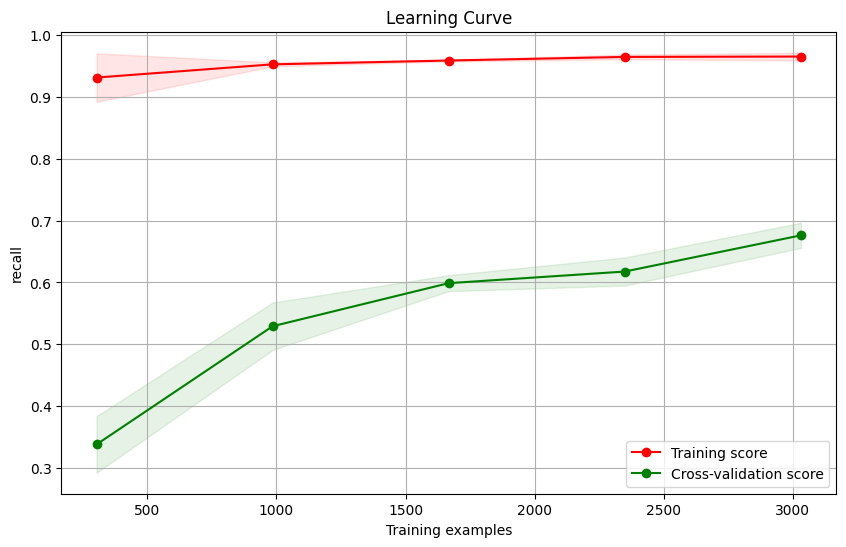

In [112]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(best_model, X_train, y_train, cv=cv)

**Les variables importants**

DEBTINC    0.257051
DELINQ     0.111525
CLAGE      0.098387
VALUE      0.084550
LOAN       0.083610
CLNO       0.079633
MORTDUE    0.074252
YOJ        0.060421
DEROG      0.056885
NINQ       0.040250
dtype: float64


<Axes: >

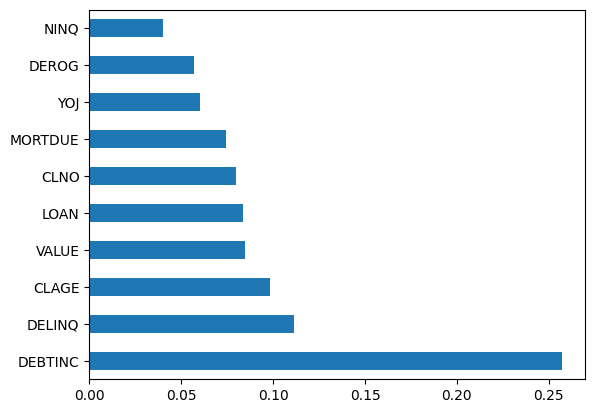

In [113]:
# Calcul de l'importance des caractéristiques (coefficients) dans le meilleur modèle de forêt aléatoire
coefficients_importance=best_model.feature_importances_
coefficients_importance=pd.Series(coefficients_importance,index=X_train.columns.values).sort_values(ascending=False)[:10]
print(coefficients_importance)
coefficients_importance.plot(kind='barh')

On remarque donc que DEBTINC est la variable qui permet de distinguer le mieux entre la classe 1 et la classe 0

#**Technique d'oversampling**

## Random Oversampling

In [114]:
# Instanciation du modèle de randomOversampling
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)
print(f'Resampled dataset samples per class: {Counter(y_train_ros)}') #affichage du nombre d'echantillons

Resampled dataset samples per class: Counter({0: 3643, 1: 3643})


### Random Forest

In [115]:
param_grid = {
    'n_estimators': [20, 30, 60, 80, 100], #nombre d'arbre dans la forêt
    'max_depth': [None, 10, 20],  # Profondeur maximale de l'arbre
    'min_samples_split': [2, 5, 10], # Nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_leaf': [1, 2, 4]  # Nombre minimum d'échantillons requis pour être à un nœud feuille
}

stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rf_ros = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_ros, param_grid, cv=stratified_cv, scoring='recall', n_jobs=-1)


grid_search.fit(X_train_ros, y_train_ros)


print("Best Hyperparameters:", grid_search.best_params_)


print("Best Cross-Validation Score:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80}
Best Cross-Validation Score: 0.9939598149617064


In [116]:
best_model = grid_search.best_estimator_ #Obtention du meilleur modèle à partir des résultats de la recherche par grille
y_pred_train = best_model.predict(X_train_ros)
y_pred_test = best_model.predict(X_test)

print("Train Recall score:", recall_score(y_train_ros, y_pred_train))
print("Test Recall score:", recall_score(y_test, y_pred_test))


print("Train Balanced accuracy score:", balanced_accuracy_score(y_train_ros, y_pred_train))
print("Test Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred_test))

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

Train Recall score: 1.0
Test Recall score: 0.7787610619469026
Train Balanced accuracy score: 1.0
Test Balanced accuracy score: 0.8646823970546808
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       911
           1       0.80      0.78      0.79       226

    accuracy                           0.92      1137
   macro avg       0.87      0.86      0.87      1137
weighted avg       0.92      0.92      0.92      1137



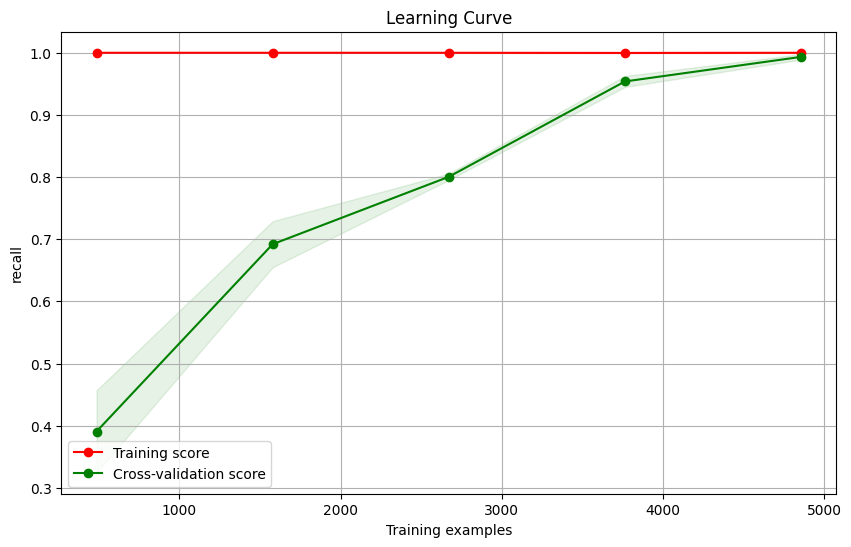

In [117]:
cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(best_model, X_train_ros, y_train_ros, cv=cv)

### Arbre de décision

In [118]:
decision_tree = tree.DecisionTreeClassifier() # Création d'une instance du modèle d'arbre de décision
decision_tree.fit(X_train_ros, y_train_ros)

DecisionTreeClassifier()

In [119]:
grid_param={
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # Définition de la stratégie de cross-validation avec StratifiedKFold
grid_search=GridSearchCV(estimator=decision_tree,param_grid=grid_param,cv=cv,n_jobs=-1)
grid_search.fit(X_train_ros,y_train_ros)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [120]:
print(grid_search.best_params_)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [121]:
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train_ros)
y_pred_test = best_model.predict(X_test)

print("Train Recall score:", recall_score(y_train_ros, y_pred_train))
print("Test Recall score:", recall_score(y_test, y_pred_test))


print("Train Balanced accuracy score:", balanced_accuracy_score(y_train_ros, y_pred_train))
print("Test Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred_test))

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

Train Recall score: 1.0
Test Recall score: 0.6150442477876106
Train Balanced accuracy score: 0.9980785067252265
Test Balanced accuracy score: 0.7734935838279435
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       911
           1       0.69      0.62      0.65       226

    accuracy                           0.87      1137
   macro avg       0.80      0.77      0.79      1137
weighted avg       0.86      0.87      0.87      1137



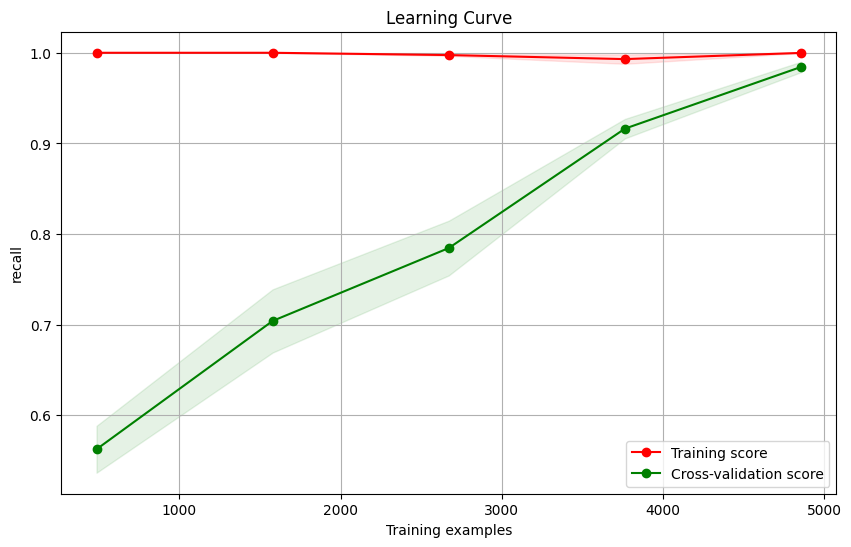

In [122]:
cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(best_model, X_train_ros, y_train_ros, cv=cv)

### Logisitic regression

In [123]:
lg_ros=LogisticRegression()
lg_ros.fit(X_train_ros,y_train_ros)

y_pred_train = lg_ros.predict(X_train_ros)
y_pred_test = lg_ros.predict(X_test)

print("Train Recall score:", recall_score(y_train_ros, y_pred_train))
print("Test Recall score:", recall_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

print("Train Balanced accuracy score:", balanced_accuracy_score(y_train_ros, y_pred_train))
print("Test Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred_test))

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

Train Recall score: 0.6771891298380456
Test Recall score: 0.7123893805309734
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       911
           1       0.45      0.71      0.55       226

    accuracy                           0.77      1137
   macro avg       0.68      0.75      0.70      1137
weighted avg       0.82      0.77      0.78      1137

Train Balanced accuracy score: 0.7318144386494647
Test Balanced accuracy score: 0.746425206182062
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       911
           1       0.45      0.71      0.55       226

    accuracy                           0.77      1137
   macro avg       0.68      0.75      0.70      1137
weighted avg       0.82      0.77      0.78      1137



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


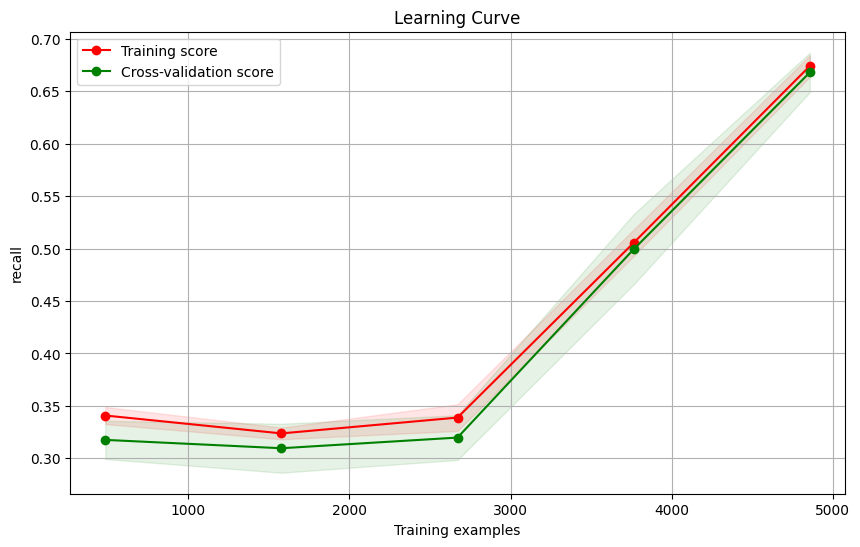

In [124]:
cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(lg_ros, X_train_ros, y_train_ros, cv=cv) # Utilisation de la fonction plot_learning_curve pour générer la courbe d'apprentissage

<Axes: ylabel='Feature'>

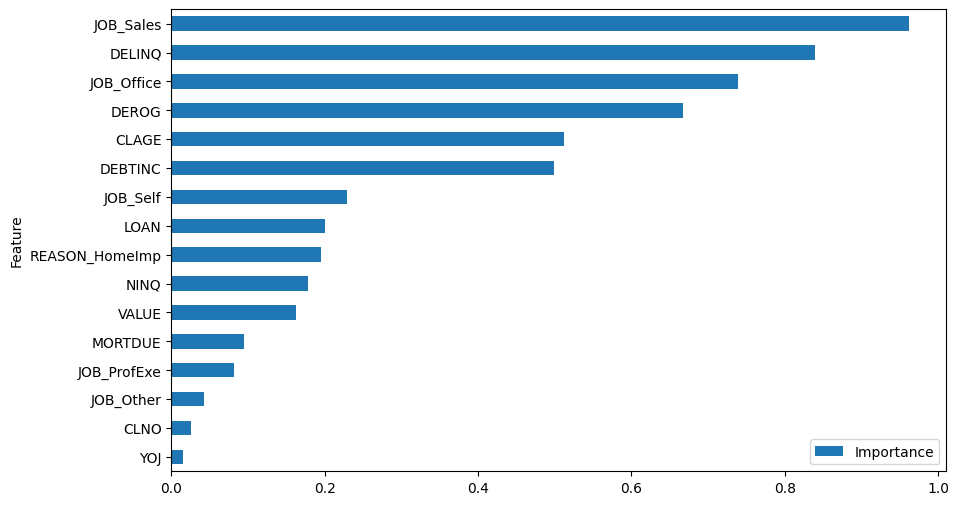

In [163]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_ros = scaler.fit_transform(X_train_ros)
X_test = scaler.transform(X_test)

coefficients = lg_ros.coef_[0]

feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10,6))

## SMOTE



Pour créer un individu synthétique, les étapes définies dans l’algorithme du SMOTE sont les suivantes :

1. Sélectionner aléatoirement une observation minoritaire “initiale”.
2. Identifier ses k plus proches voisins parmi les observations minoritaires (où k est un paramètre défini par l’utilisateur).
3. Choisir aléatoirement l’un des k plus proches voisins.
4. Générer aléatoirement un coefficient

5. Créer un nouvel individu entre l’observation initiale et le plus proche voisin choisi, selon la valeur du coefficient . Par exemple, si
, le nouvel individu sera positionné à mi-chemin entre l’observation initiale et le plus proche voisin choisi.

In [125]:
#Note: The SMOTE and its related techniques are only applied to the training dataset so that we fit our algorithm properly on the data. The test data remains unchanged so that it correctly represents the original data.
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote= smote.fit_resample(X_train, y_train)
print(f'Resampled dataset samples per class: {Counter(y_train_smote)}')

Resampled dataset samples per class: Counter({0: 3643, 1: 3643})


**Aprés avoir echantillonner nos données avec SMOTE,on recalcule les performances de nos modèles**

### Random Forest

In [126]:
param_grid = {
    'n_estimators': [20, 30, 60, 80, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
rf_smote = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_smote, param_grid, cv=stratified_cv, scoring='recall', n_jobs=-1)


grid_search.fit(X_train_smote, y_train_smote)


print("Best Hyperparameters:", grid_search.best_params_)


print("Best Cross-Validation Score:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score: 0.9467458977679247


In [127]:
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train_smote)
y_pred_test = best_model.predict(X_test)

print("Train Recall score:", recall_score(y_train_smote, y_pred_train))
print("Test Recall score:", recall_score(y_test, y_pred_test))


print("Train Balanced accuracy score:", balanced_accuracy_score(y_train_smote, y_pred_train))
print("Test Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred_test))

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

Train Recall score: 1.0
Test Recall score: 0.8230088495575221
Train Balanced accuracy score: 1.0
Test Balanced accuracy score: 0.8884528331212418
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       911
           1       0.82      0.82      0.82       226

    accuracy                           0.93      1137
   macro avg       0.89      0.89      0.89      1137
weighted avg       0.93      0.93      0.93      1137



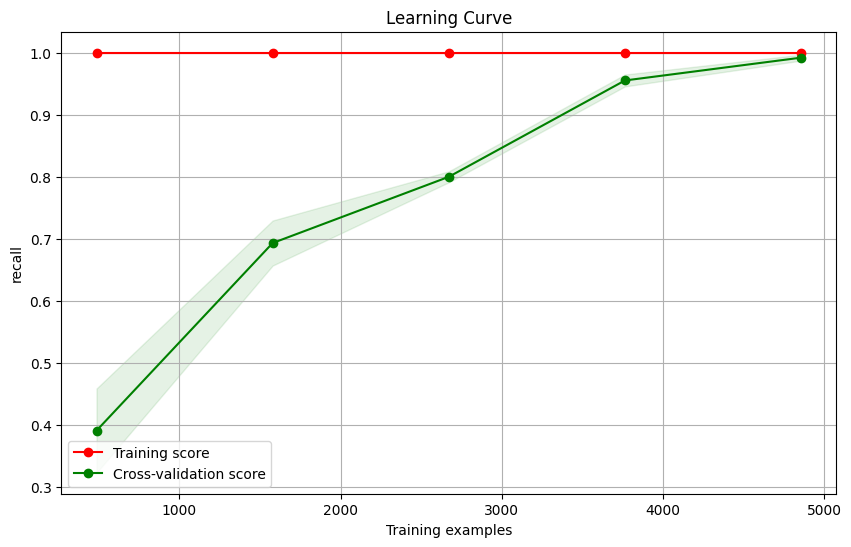

In [128]:
cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(best_model, X_train_ros, y_train_ros, cv=cv)

### Arbre de décision

In [129]:
decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier()

In [130]:
grid_param={
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search=GridSearchCV(estimator=decision_tree,param_grid=grid_param,cv=cv,n_jobs=-1)
grid_search.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [131]:
print(grid_search.best_params_)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [132]:
best_model = grid_search.best_estimator_

y_pred_train = best_model.predict(X_train_smote)
y_pred_test = best_model.predict(X_test)

print("Train Balanced Accuracy Score:", balanced_accuracy_score(y_train_smote, y_pred_train))
print("Test Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred_test))
print("Train recall Score:", recall_score(y_train_smote, y_pred_train))
print("Test recall Score:", recall_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Train Balanced Accuracy Score: 0.9993137524018666
Test Balanced Accuracy Score: 0.8046030327462771
Train recall Score: 0.9997255009607466
Test recall Score: 0.7123893805309734
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       911
           1       0.63      0.71      0.67       226

    accuracy                           0.86      1137
   macro avg       0.78      0.80      0.79      1137
weighted avg       0.87      0.86      0.86      1137



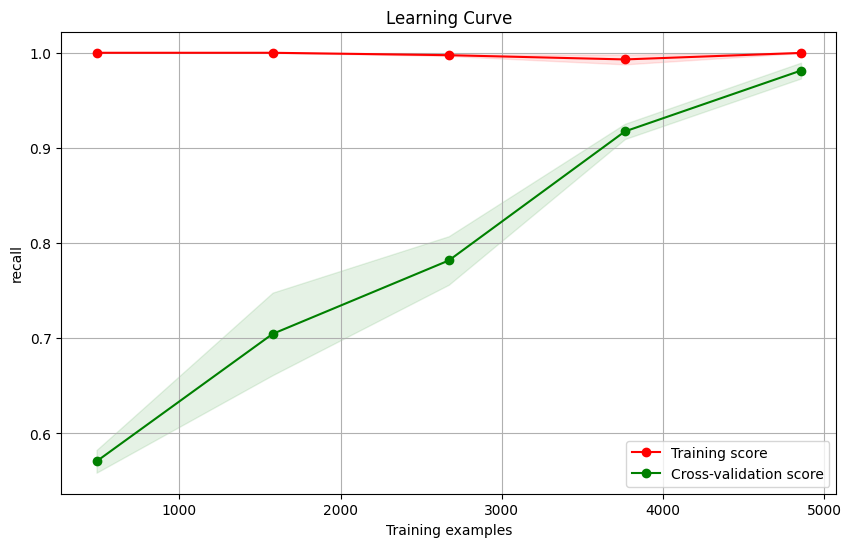

In [133]:
cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(best_model, X_train_ros, y_train_ros, cv=cv)

### Régression Logistique

In [134]:
lg_smote=LogisticRegression()
lg_smote.fit(X_train_smote,y_train_smote)

y_pred_train = lg_smote.predict(X_train_smote)
y_pred_test = lg_smote.predict(X_test)

print("Train Recall score:", recall_score(y_train_smote, y_pred_train))
print("Test Recall score:", recall_score(y_test, y_pred_test))

print("Train Balanced accuracy score:", balanced_accuracy_score(y_train_smote, y_pred_train))
print("Test Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred_test))

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

Train Recall score: 0.7493823771616799
Test Recall score: 0.6592920353982301
Train Balanced accuracy score: 0.7705188031841887
Test Balanced accuracy score: 0.7253650078198615
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       911
           1       0.44      0.66      0.53       226

    accuracy                           0.77      1137
   macro avg       0.67      0.73      0.69      1137
weighted avg       0.81      0.77      0.78      1137



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


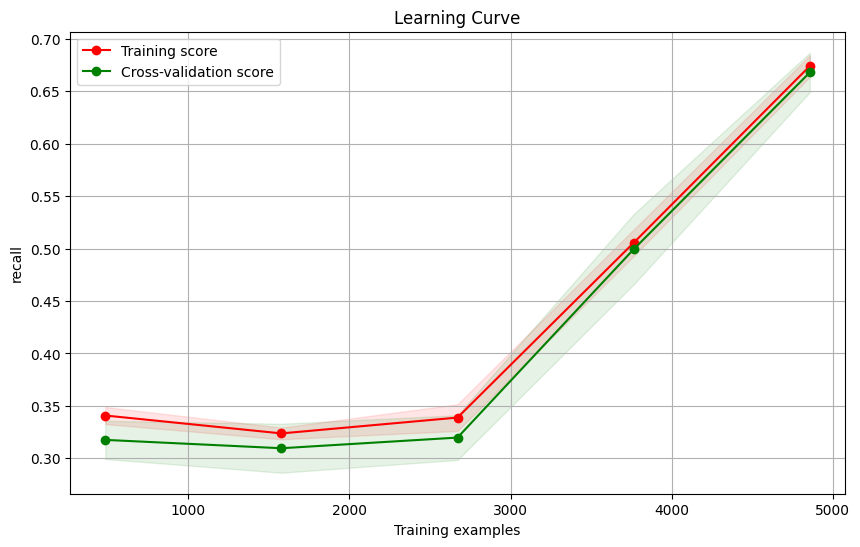

In [135]:
cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(lg_smote, X_train_ros, y_train_ros, cv=cv)

#**Undersampling techniques**

## Random undersampling

In [136]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)
print(f'Resampled dataset samples per class: {Counter(y_train_rus)}')

Resampled dataset samples per class: Counter({0: 905, 1: 905})


### Random Forest

In [137]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [20, 30, 60, 80, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


rf_us = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_us, param_grid, cv=3, scoring='recall', n_jobs=-1)


grid_search.fit(X_train_rus, y_train_rus)


print("Best Hyperparameters:", grid_search.best_params_)


print("Best Cross-Validation Score:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 20}
Best Cross-Validation Score: 0.8728997528473889


In [138]:
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train_rus)
y_pred_test = best_model.predict(X_test)

print("Train Recall score:", recall_score(y_train_rus, y_pred_train))
print("Test Recall score:", recall_score(y_test, y_pred_test))


print("Train Balanced accuracy score:", balanced_accuracy_score(y_train_rus, y_pred_train))
print("Test Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred_test))

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

Train Recall score: 0.9646408839779006
Test Recall score: 0.8761061946902655
Train Balanced accuracy score: 0.9624309392265193
Test Balanced accuracy score: 0.8617633059071526
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       911
           1       0.59      0.88      0.70       226

    accuracy                           0.85      1137
   macro avg       0.78      0.86      0.80      1137
weighted avg       0.89      0.85      0.86      1137



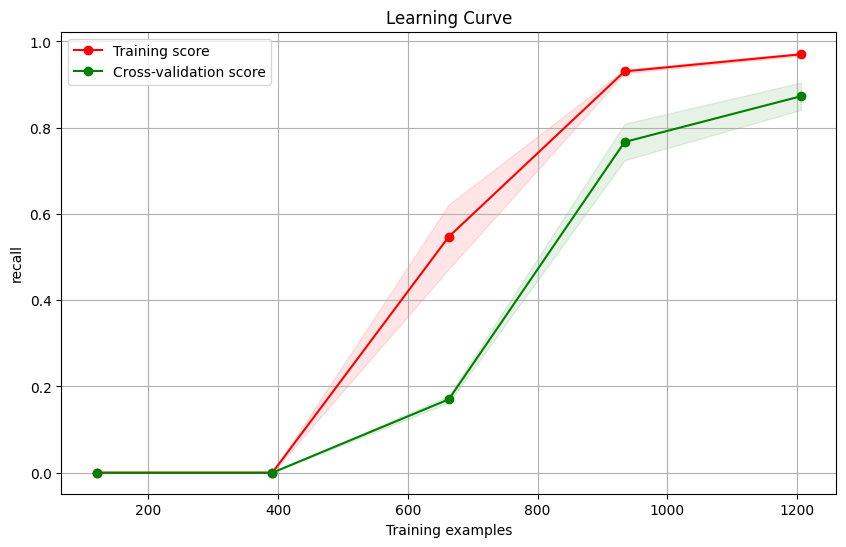

In [139]:
cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(best_model, X_train_rus, y_train_rus, cv=cv)

### Arbre de décision

In [140]:
decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(X_train_rus, y_train_rus)

DecisionTreeClassifier()

In [141]:
grid_param={
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search=GridSearchCV(estimator=decision_tree,param_grid=grid_param,cv=cv,n_jobs=-1)
grid_search.fit(X_train_rus,y_train_rus)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [142]:
print(grid_search.best_params_)

{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [143]:
best_model = grid_search.best_estimator_

y_pred_train = best_model.predict(X_train_rus)
y_pred_test = best_model.predict(X_test)

print("Train Balanced Accuracy Score:", balanced_accuracy_score(y_train_rus, y_pred_train))
print("Test Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred_test))
print("Train recall Score:", recall_score(y_train_rus, y_pred_train))
print("Test recall Score:", recall_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Train Balanced Accuracy Score: 0.9270718232044199
Test Balanced Accuracy Score: 0.7784283535548799
Train recall Score: 0.9082872928176795
Test recall Score: 0.7566371681415929
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       911
           1       0.48      0.76      0.59       226

    accuracy                           0.79      1137
   macro avg       0.71      0.78      0.73      1137
weighted avg       0.84      0.79      0.81      1137



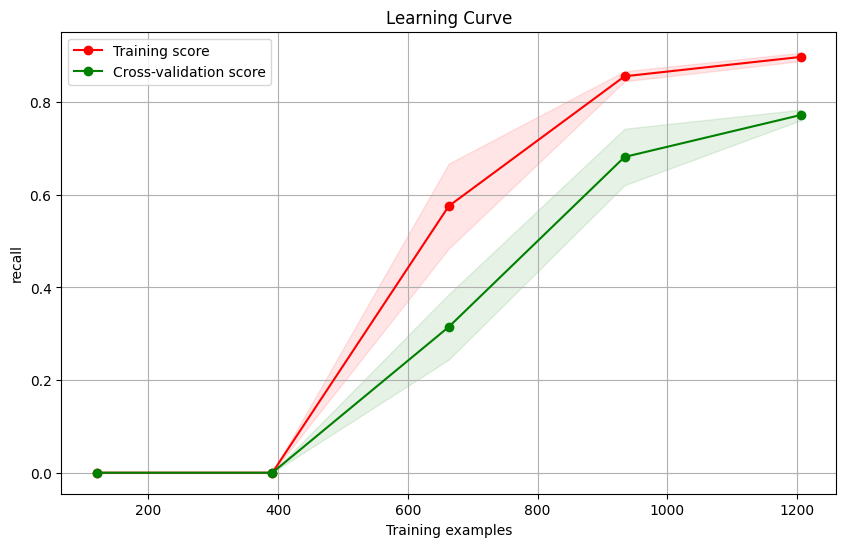

In [144]:
cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(best_model, X_train_rus, y_train_rus, cv=cv)

### Régression logistique

In [145]:
lg_rus=LogisticRegression()
lg_rus.fit(X_train_rus,y_train_rus)

y_pred_train = lg_rus.predict(X_train_rus)
y_pred_test = lg_rus.predict(X_test)

print("Train Recall score:", recall_score(y_train_rus, y_pred_train))
print("Test Recall score:", recall_score(y_test, y_pred_test))

print("Train Balanced accuracy score:", balanced_accuracy_score(y_train_rus, y_pred_train))
print("Test Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred_test))

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

Train Recall score: 0.6651933701657459
Test Recall score: 0.7168141592920354
Train Balanced accuracy score: 0.7232044198895028
Test Balanced accuracy score: 0.7420514265175875
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84       911
           1       0.43      0.72      0.54       226

    accuracy                           0.76      1137
   macro avg       0.67      0.74      0.69      1137
weighted avg       0.82      0.76      0.78      1137



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


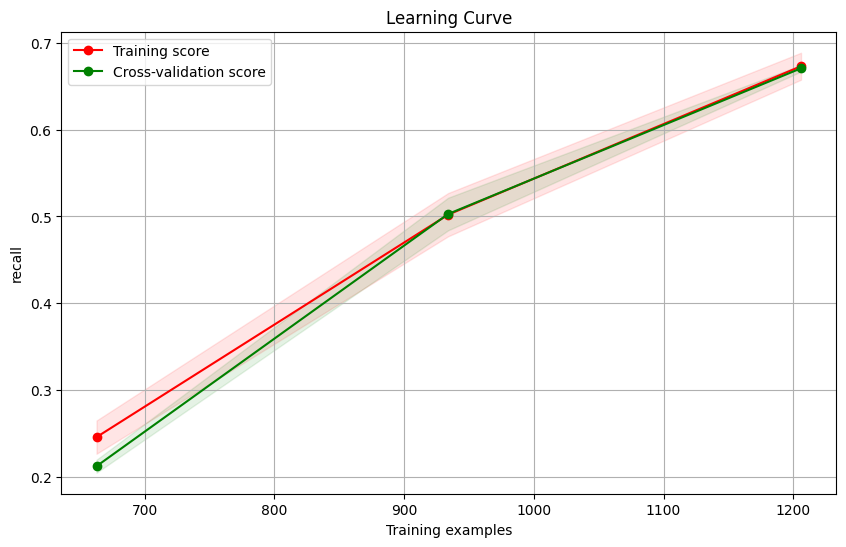

In [146]:
cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(lg_rus, X_train_rus, y_train_rus, cv=cv)

## Algorithme NearMiss

In [147]:
nm = NearMiss()
X_train_nm, y_train_nm= nm.fit_resample(X_train, y_train)
print(f'Resampled dataset samples per class: {Counter(y_train_nm)}')

Resampled dataset samples per class: Counter({0: 905, 1: 905})


### Random Forest

In [148]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [20, 30, 60, 80, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


rf_nm = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf_nm, param_grid, cv=3, scoring='recall', n_jobs=-1)


grid_search.fit(X_train_nm, y_train_nm)


print("Best Hyperparameters:", grid_search.best_params_)


print("Best Cross-Validation Score:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 80}
Best Cross-Validation Score: 0.9082711784852552


In [149]:
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train_nm)
y_pred_test = best_model.predict(X_test)

print("Train Recall score:", recall_score(y_train_nm, y_pred_train))
print("Test Recall score:", recall_score(y_test, y_pred_test))


print("Train Balanced accuracy score:", balanced_accuracy_score(y_train_nm, y_pred_train))
print("Test Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred_test))

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

Train Recall score: 0.988950276243094
Test Recall score: 0.9070796460176991
Train Balanced accuracy score: 0.9906077348066298
Test Balanced accuracy score: 0.6966792302536355
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.95      0.49      0.64       911
           1       0.30      0.91      0.46       226

    accuracy                           0.57      1137
   macro avg       0.63      0.70      0.55      1137
weighted avg       0.83      0.57      0.61      1137



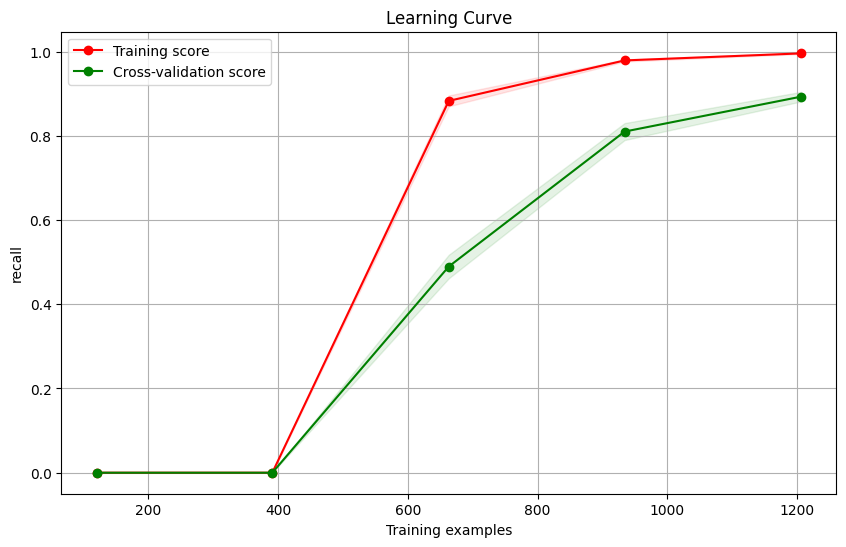

In [150]:
cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(best_model, X_train_nm, y_train_nm, cv=cv)

### Decision Trees

In [151]:
decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(X_train_nm, y_train_nm)

DecisionTreeClassifier()

In [152]:
grid_param={
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search=GridSearchCV(estimator=decision_tree,param_grid=grid_param,cv=cv,n_jobs=-1)
grid_search.fit(X_train_nm,y_train_nm)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [153]:
print(grid_search.best_params_)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [154]:
best_model = grid_search.best_estimator_

y_pred_train = best_model.predict(X_train_nm)
y_pred_test = best_model.predict(X_test)

print("Train Balanced Accuracy Score:", balanced_accuracy_score(y_train_nm, y_pred_train))
print("Test Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred_test))
print("Train recall Score:", recall_score(y_train_nm, y_pred_train))
print("Test recall Score:", recall_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Train Balanced Accuracy Score: 0.9861878453038674
Test Balanced Accuracy Score: 0.6880725255724042
Train recall Score: 0.9779005524861878
Test recall Score: 0.8097345132743363
              precision    recall  f1-score   support

           0       0.92      0.57      0.70       911
           1       0.32      0.81      0.46       226

    accuracy                           0.61      1137
   macro avg       0.62      0.69      0.58      1137
weighted avg       0.80      0.61      0.65      1137



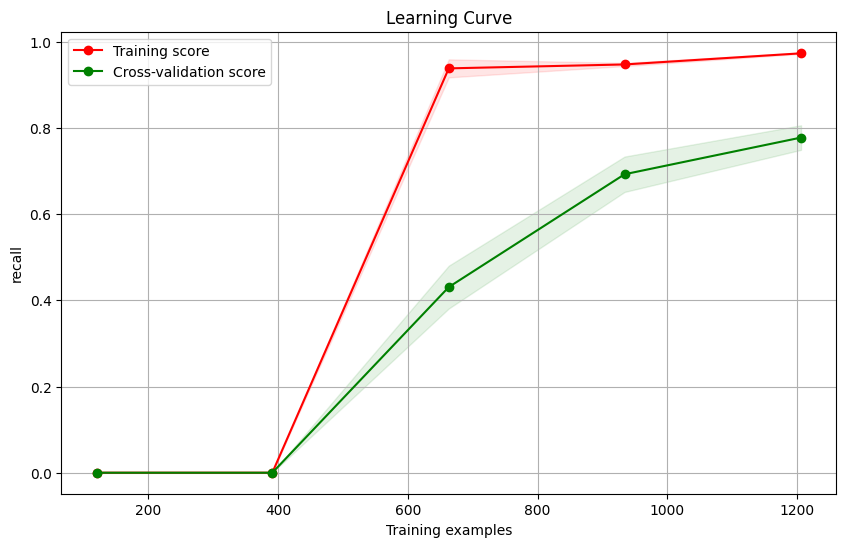

In [155]:
cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(best_model, X_train_rus, y_train_rus, cv=cv)

### Régression logistique

In [156]:
lg_nm=LogisticRegression()
lg_nm.fit(X_train_nm,y_train_nm)

y_pred_train = lg_nm.predict(X_train_nm)
y_pred_test = lg_nm.predict(X_test)

print("Train Recall score:", recall_score(y_train_nm, y_pred_train))
print("Test Recall score:", recall_score(y_test, y_pred_test))

print("Train Balanced accuracy score:", balanced_accuracy_score(y_train_nm, y_pred_train))
print("Test Balanced accuracy score:", balanced_accuracy_score(y_test, y_pred_test))

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

Train Recall score: 0.7138121546961326
Test Recall score: 0.7389380530973452
Train Balanced accuracy score: 0.7944751381215469
Test Balanced accuracy score: 0.6598093119493311
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.90      0.58      0.71       911
           1       0.30      0.74      0.43       226

    accuracy                           0.61      1137
   macro avg       0.60      0.66      0.57      1137
weighted avg       0.78      0.61      0.65      1137



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


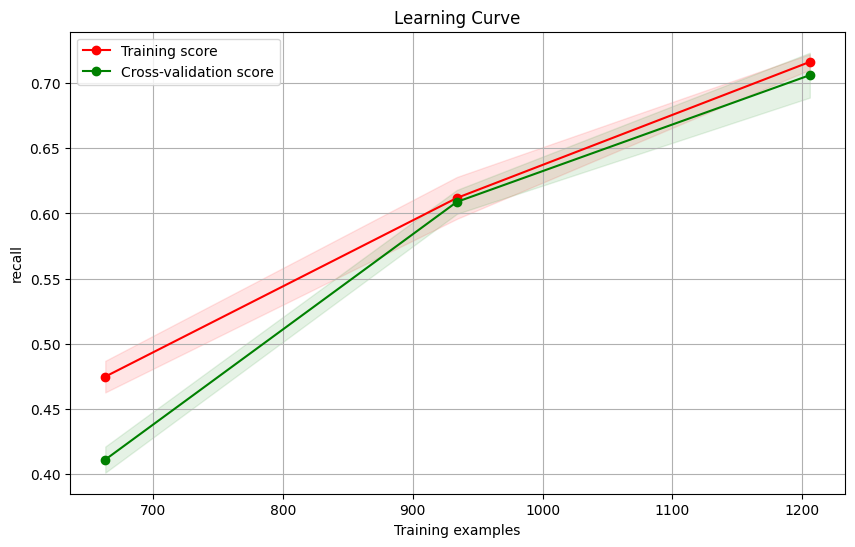

In [157]:
cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
plot_learning_curve(lg_nm, X_train_nm, y_train_nm, cv=cv)